# Previsão da Temperatura mínima da cidade de Melbourne (AUS)

## Dataset utilizado
- Série temporal de temperatura mínima diária referente à cidade de Melbourne, Austrália, no período de 1981 a 1990. Dados retirados de: [Australian Bureau of Meteorology](http://www.bom.gov.au/)

### Guilherme Teixeira Semissatto
- RA: 140656
- e-mail: semissatto@gmail.com

# Parte 1

### Parte 1 - Objetivos
- Para o exercício 1, deve-se explorar um modelo linear de previsão, tal que:
![preditor-linear](./Imagens/preditor-linear.png)
- Para este caso, os dados de 1990 são reservados para teste
- Além disso, utilizar um esquema de __validação cruzada do tipo k-fold__ para selecionar o melhor valor do hiperparâmetro K. Neste caso, o hiperparâmetro é o número de dias anteriores ao dia em que se deseja prever a temperatura os quais devem ser avaliados de K = 1 ... 30
- Como parâmetro de qualidade do modelo preditor, deve-se utilizar o valor __RMSE (root mean squared error)__

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# import dos dados
df = pd.read_csv("daily-minimum-temperatures.csv")

In [3]:
# visualização do dataset
df.head(10)

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
5,1981-01-06,15.8
6,1981-01-07,15.8
7,1981-01-08,17.4
8,1981-01-09,21.8
9,1981-01-10,20.0


In [4]:
# linhas e colunas do dataset
df.shape

(3650, 2)

In [5]:
# estatísticas do dataset
df.describe()

,Temp
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


In [6]:
# checka se o dataset não possui valores NaN/Nulos
df.isnull().any().any()

False

In [7]:
# separa os dados de treinamento e teste
training = df.iloc[0:3285, :]
test = df.iloc[3285:3650, :]

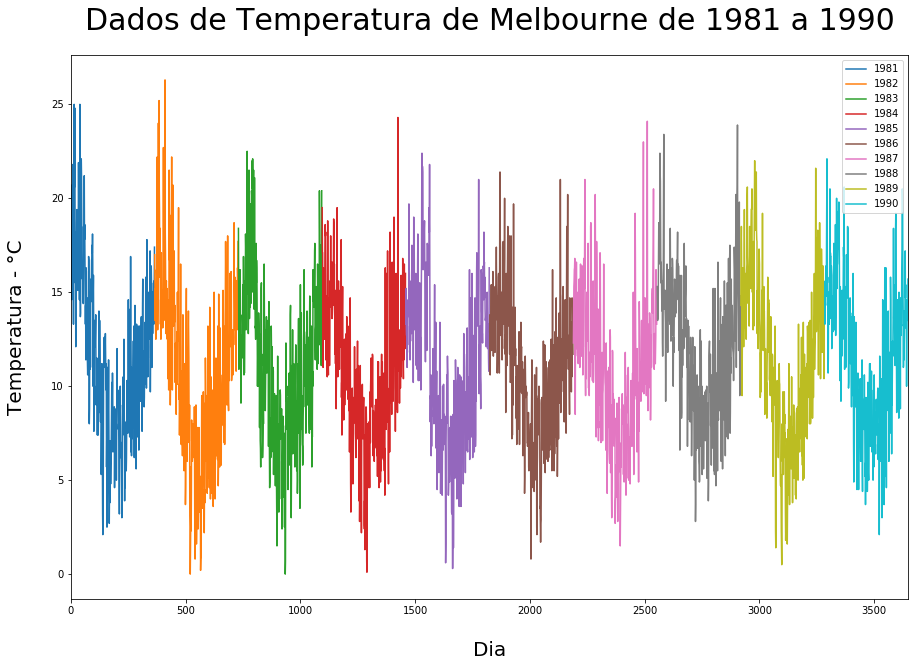

In [8]:
# plota os dados com base nos anos
plt.figure(figsize = (15, 10))
df_1981 = df.iloc[0:365*1,:]
df_1981["Temp"].plot(label = "1981")
df_1982 = df.iloc[365*1:365*2-1,:]
df_1982["Temp"].plot(label = "1982")
df_1983 = df.iloc[365*2:365*3-1,:]
df_1983["Temp"].plot(label = "1983")
df_1984 = df.iloc[365*3:365*4-1,:]
df_1984["Temp"].plot(label = "1984")
df_1985 = df.iloc[365*4:365*5-1,:]
df_1985["Temp"].plot(label = "1985")
df_1986 = df.iloc[365*5:365*6-1,:]
df_1986["Temp"].plot(label = "1986")
df_1987 = df.iloc[365*6:365*7-1,:]
df_1987["Temp"].plot(label = "1987")
df_1988 = df.iloc[365*7:365*8-1,:]
df_1988["Temp"].plot(label = "1988")
df_1989 = df.iloc[365*8:365*9-1,:]
df_1989["Temp"].plot(label = "1989")
df_1990 = df.iloc[365*9:365*10-1,:]
df_1990["Temp"].plot(label = "1990")
plt.title("Dados de Temperatura de Melbourne de 1981 a 1990", size = 30, pad = 25)
plt.ylabel("Temperatura - °C", size = 20, labelpad = 25)
plt.xlabel("Dia", size = 20, labelpad = 25)
plt.legend()

### Pseudo-inversa
- A função abaixo retorna a matriz de pesos __W__ a partir do conjunto de dados __$\pmb\phi$__ e do conjunto de dados target __Y__, seguindo a solução ótima fechada (pseudo inversa) como a seguir:
![pseudo-inversa](./Imagens/pseudo-inversa.png)

In [9]:
def fit_reg_lin(X, Y, add_ones = False):
    '''
    Função que gera um modelo de Regressão Linear baseado solução fechada (pseudo inversa) do tipo 
    y' = w0 + w1*X1 + ... + wk*Xk, a partir de um vetor de amostras X e Y
    output: [w0, w1, ..., wn]
    '''
    # adiciona uma coluna de 1's para os bias, caso necessário
    if add_ones:
        phi = np.c_[np.ones(len(X)), X]
    else:
        phi = X
    
    # transforma a matriz Y em uma matriz coluna   
    Y = np.matrix(Y).reshape((len(Y), 1))
    
    # retorna a matriz de pesos w = (phi.T @ phi)-¹ @ phi.T @ Y
    return (np.linalg.inv(phi.T.dot(phi)).dot(phi.T).dot(Y))

In [10]:
def rmse(y, y_est):
    ''' Esta função retorna a raíz
        da somatória do erro quadrático médio entre dois vetores (y e y_est de entrada)'''
    sum = 0
    if len(y) != len(y_est):
        return -1
    
    for i in range(len(y)):
        error = (y[i] - y_est[i]) ** 2
        sum += error
        
    return np.sqrt(sum/len(y))

In [11]:
def kfold_n(data = pd.DataFrame(), K = 2, n = 1):
    '''
    Esta função divide o dataset em K pastas para serem treinados com n dias anteriores
    Data: dataset a ser dividido
    K: número de pastas
    n: número de dias corridos
    Retorno:
    Uma lista de K elementos em que cada elemento é a k-ésima pasta
    Retorna as k-1 pastas para treinamento, e a pasta para validação
    '''
    if (K == 1):
        print ("K must be > 1")
        return -1
        
    number_elements = round(len(data)/K)
    folders = list(range(K))
    
    for i in range(K):
        # Limita o range da última pasta, pois não há dados futuros
        if (i == K-1):
            folders[i] = data.iloc[number_elements*i : number_elements*(i + 1), :]
        else:
            folders[i] = data.iloc[number_elements*i : number_elements*(i + 1) + n, :]
    
    return folders 

In [12]:
def phi_y(data = pd.DataFrame(), n = 1):
    '''
    Esta função gera a matriz Phi e a matriz Y, a partir do dataset data, considerando n dias anteriores
    Retorno:
    Uma lista de 2 elementos, sendo o primeiro elemento a matriz Phi, e o segundo elemento a matriz Y
    '''
    Phi = np.zeros((len(data) - n, n))
    Y = np.zeros((len(data) - n, 1))
    for i in range(len(data) - n):
        Phi[i] = data["Temp"].iloc[i : i+n]
        Y[i] = data["Temp"].iloc[i+n]

    return [Phi, Y]

# Validação cruzada com método K-fold
O código a seguir, resumidamente, realiza os seguintes passos:
- divide o dataset em K pastas
- gera dados de treinamento das K-1 pastas, considerando N dias anteriores
- gera dados de validação da pasta, considerando N dias anteriores
- para cada N, obtém K modelos preditores
- calcula RMSE dos K modelos preditores e a respectiva média de RMSE para os K modelos para cada N
- plota a média RMSE obtida anterior para cada N
- obtém o valor de N para qual se obteve a menor média RMSE
- obtém o melhor modelo a partir da identificação do melhor hiperparâmetro N
- aplica o melhor modelo para os dados de teste de 1990, plotando a série temporal de testes juntamente com as estimativas

# Folds utilizados
- Para este dataset, utilizou-se uma divisão em __9 pastas__, tendo em vista que a temperatura anual tem um perfil periódico e se repete a cada ano. Como restaram 9 anos de dados para treinamento e validação, 9 pastas foram escolhidas
- Desta maneira, temos a seguinte divisão de dados para a validação cruzada:
![k-folds](./Imagens/k-folds.png)

# Em seguida, os dados foram sujeitos a 9 experiências de aprendizado, um para cada Fold (linha da imagem da acima)
### Aprendizado #0 
- folds 0 - 8: treinamento
- fold 8: validação

In [13]:
training_k_0 = list(range(30))
validation_k_0 = list(range(30))
model_k_0 = list(range(30))
RMSE_k_0 = list(range(30))

# este laço retorna 30 modelos e 30 valores de erro RMSE para a k-ésima seleção de pasta do k-fold
for i in range(0,30):
    # prepara os dados para treinamento e validação
    folders = kfold_n(data = df, K = 9, n = i+1)
    training_k_0[i] = phi_y(data = pd.concat([folders[0],\
                                              folders[1],\
                                              folders[2],\
                                              folders[3],\
                                              folders[4],\
                                              folders[5],\
                                              folders[6],\
                                              folders[7]]),\
                            n = i+1)
    validation_k_0[i] = (phi_y(data = folders[8], n = i+1))

    # obtém o modelo a partir da pseudo-inversa
    model_k_0[i] = (fit_reg_lin(X = training_k_0[i][0], Y = training_k_0[i][1], add_ones = 1))

    # calcula as saídas estimadas com o modelo acima, comparando-as com as saídas esperadas
    validation_k_0[i][0] = np.c_[np.ones(len(validation_k_0[i][0])), validation_k_0[i][0]]
    y_estimated = validation_k_0[i][0].dot(model_k_0[i])
    RMSE_k_0[i] = float(rmse(y_estimated, validation_k_0[i][1]))

### Aprendizado #1
- folds 0, 1, 2, 3, 4, 5, 6, 8: treinamento
- fold 7: validação

In [14]:
training_k_1 = list(range(30))
validation_k_1 = list(range(30))
model_k_1 = list(range(30))
RMSE_k_1 = list(range(30))

# este laço retorna 30 modelos e 30 valores de erro RMSE para a k-ésima seleção de pasta do k-fold
for i in range(0,30):
    # prepara os dados para treinamento e validação
    folders = kfold_n(data = df, K = 9, n = i+1)
    training_k_1[i] = phi_y(data = pd.concat([folders[0],\
                                              folders[1],\
                                              folders[2],\
                                              folders[3],\
                                              folders[4],\
                                              folders[5],\
                                              folders[6],\
                                              folders[8]]),\
                            n = i+1)
    validation_k_1[i] = (phi_y(data = folders[7], n = i+1))

    # obtém o modelo a partir da pseudo-inversa
    model_k_1[i] = (fit_reg_lin(X = training_k_1[i][0], Y = training_k_1[i][1], add_ones = 1))

    # calcula as saídas estimadas com o modelo acima, comparando-as com as saídas esperadas
    validation_k_1[i][0] = np.c_[np.ones(len(validation_k_1[i][0])), validation_k_1[i][0]]
    y_estimated = validation_k_1[i][0].dot(model_k_1[i])
    RMSE_k_1[i] = float(rmse(y_estimated, validation_k_1[i][1]))

### Aprendizado #2
- folds 0, 1, 2, 3, 4, 5, 7, 8: treinamento
- fold 6: validação

In [15]:
training_k_2 = list(range(30))
validation_k_2 = list(range(30))
model_k_2 = list(range(30))
RMSE_k_2 = list(range(30))

# este laço retorna 30 modelos e 30 valores de erro RMSE para a k-ésima seleção de pasta do k-fold
for i in range(0,30):
    # prepara os dados para treinamento e validação
    folders = kfold_n(data = df, K = 9, n = i+1)
    training_k_2[i] = phi_y(data = pd.concat([folders[0],\
                                              folders[1],\
                                              folders[2],\
                                              folders[3],\
                                              folders[4],\
                                              folders[5],\
                                              folders[7],\
                                              folders[8]]),\
                            n = i+1)
    validation_k_2[i] = (phi_y(data = folders[6], n = i+1))

    # obtém o modelo a partir da pseudo-inversa
    model_k_2[i] = (fit_reg_lin(X = training_k_2[i][0], Y = training_k_2[i][1], add_ones = 1))

    # calcula as saídas estimadas com o modelo acima, comparando-as com as saídas esperadas
    validation_k_2[i][0] = np.c_[np.ones(len(validation_k_2[i][0])), validation_k_2[i][0]]
    y_estimated = validation_k_2[i][0].dot(model_k_2[i])
    RMSE_k_2[i] = float(rmse(y_estimated, validation_k_2[i][1]))

### Aprendizado #3
- folds 0, 1, 2, 3, 4, 6, 7, 8: treinamento
- fold 5: validação

In [16]:
training_k_3 = list(range(30))
validation_k_3 = list(range(30))
model_k_3 = list(range(30))
RMSE_k_3 = list(range(30))

# este laço retorna 30 modelos e 30 valores de erro RMSE para a k-ésima seleção de pasta do k-fold
for i in range(0,30):
    # prepara os dados para treinamento e validação
    folders = kfold_n(data = df, K = 9, n = i+1)
    training_k_3[i] = phi_y(data = pd.concat([folders[0],\
                                              folders[1],\
                                              folders[2],\
                                              folders[3],\
                                              folders[4],\
                                              folders[6],\
                                              folders[7],\
                                              folders[8]]),\
                            n = i+1)
    validation_k_3[i] = (phi_y(data = folders[5], n = i+1))

    # obtém o modelo a partir da pseudo-inversa
    model_k_3[i] = (fit_reg_lin(X = training_k_3[i][0], Y = training_k_3[i][1], add_ones = 1))

    # calcula as saídas estimadas com o modelo acima, comparando-as com as saídas esperadas
    validation_k_3[i][0] = np.c_[np.ones(len(validation_k_3[i][0])), validation_k_3[i][0]]
    y_estimated = validation_k_3[i][0].dot(model_k_3[i])
    RMSE_k_3[i] = float(rmse(y_estimated, validation_k_3[i][1]))

### Aprendizado #4
- folds 0, 1, 2, 3, 5, 6, 7, 8: treinamento
- fold 4: validação

In [17]:
training_k_4 = list(range(30))
validation_k_4 = list(range(30))
model_k_4 = list(range(30))
RMSE_k_4 = list(range(30))

# este laço retorna 30 modelos e 30 valores de erro RMSE para a k-ésima seleção de pasta do k-fold
for i in range(0,30):
    # prepara os dados para treinamento e validação
    folders = kfold_n(data = df, K = 9, n = i+1)
    training_k_4[i] = phi_y(data = pd.concat([folders[0],\
                                              folders[1],\
                                              folders[2],\
                                              folders[3],\
                                              folders[5],\
                                              folders[6],\
                                              folders[7],\
                                              folders[8]]),\
                            n = i+1)
    validation_k_4[i] = (phi_y(data = folders[4], n = i+1))

    # obtém o modelo a partir da pseudo-inversa
    model_k_4[i] = (fit_reg_lin(X = training_k_4[i][0], Y = training_k_4[i][1], add_ones = 1))

    # calcula as saídas estimadas com o modelo acima, comparando-as com as saídas esperadas
    validation_k_4[i][0] = np.c_[np.ones(len(validation_k_4[i][0])), validation_k_4[i][0]]
    y_estimated = validation_k_4[i][0].dot(model_k_4[i])
    RMSE_k_4[i] = float(rmse(y_estimated, validation_k_4[i][1]))

### Aprendizado #5
- folds 0, 1, 2, 4, 5, 6, 7, 8: treinamento
- fold 3: validação

In [18]:
training_k_5 = list(range(30))
validation_k_5 = list(range(30))
model_k_5 = list(range(30))
RMSE_k_5 = list(range(30))

# este laço retorna 30 modelos e 30 valores de erro RMSE para a k-ésima seleção de pasta do k-fold
for i in range(0,30):
    # prepara os dados para treinamento e validação
    folders = kfold_n(data = df, K = 9, n = i+1)
    training_k_5[i] = phi_y(data = pd.concat([folders[0],\
                                              folders[1],\
                                              folders[2],\
                                              folders[4],\
                                              folders[5],\
                                              folders[6],\
                                              folders[7],\
                                              folders[8]]),\
                            n = i+1)
    validation_k_5[i] = (phi_y(data = folders[3], n = i+1))

    # obtém o modelo a partir da pseudo-inversa
    model_k_5[i] = (fit_reg_lin(X = training_k_5[i][0], Y = training_k_5[i][1], add_ones = 1))

    # calcula as saídas estimadas com o modelo acima, comparando-as com as saídas esperadas
    validation_k_5[i][0] = np.c_[np.ones(len(validation_k_5[i][0])), validation_k_5[i][0]]
    y_estimated = validation_k_5[i][0].dot(model_k_5[i])
    RMSE_k_5[i] = float(rmse(y_estimated, validation_k_5[i][1]))

### Aprendizado #6
- folds 0, 1, 3, 4, 5, 6, 7, 8: treinamento
- fold 2: validação

In [19]:
training_k_6 = list(range(30))
validation_k_6 = list(range(30))
model_k_6 = list(range(30))
RMSE_k_6 = list(range(30))

# este laço retorna 30 modelos e 30 valores de erro RMSE para a k-ésima seleção de pasta do k-fold
for i in range(0,30):
    # prepara os dados para treinamento e validação
    folders = kfold_n(data = df, K = 9, n = i+1)
    training_k_6[i] = phi_y(data = pd.concat([folders[0],\
                                              folders[1],\
                                              folders[3],\
                                              folders[4],\
                                              folders[5],\
                                              folders[6],\
                                              folders[7],\
                                              folders[8]]),\
                            n = i+1)
    validation_k_6[i] = (phi_y(data = folders[2], n = i+1))

    # obtém o modelo a partir da pseudo-inversa
    model_k_6[i] = (fit_reg_lin(X = training_k_6[i][0], Y = training_k_6[i][1], add_ones = 1))

    # calcula as saídas estimadas com o modelo acima, comparando-as com as saídas esperadas
    validation_k_6[i][0] = np.c_[np.ones(len(validation_k_6[i][0])), validation_k_6[i][0]]
    y_estimated = validation_k_6[i][0].dot(model_k_6[i])
    RMSE_k_6[i] = float(rmse(y_estimated, validation_k_6[i][1]))

### Aprendizado #7
- folds 0, 2, 3, 4, 5, 6, 7, 8: treinamento
- fold 1: validação

In [20]:
training_k_7 = list(range(30))
validation_k_7 = list(range(30))
model_k_7 = list(range(30))
RMSE_k_7 = list(range(30))

# este laço retorna 30 modelos e 30 valores de erro RMSE para a k-ésima seleção de pasta do k-fold
for i in range(0,30):
    # prepara os dados para treinamento e validação
    folders = kfold_n(data = df, K = 9, n = i+1)
    training_k_7[i] = phi_y(data = pd.concat([folders[0],\
                                              folders[2],\
                                              folders[3],\
                                              folders[4],\
                                              folders[5],\
                                              folders[6],\
                                              folders[7],\
                                              folders[8]]),\
                            n = i+1)
    validation_k_7[i] = (phi_y(data = folders[1], n = i+1))

    # obtém o modelo a partir da pseudo-inversa
    model_k_7[i] = (fit_reg_lin(X = training_k_7[i][0], Y = training_k_7[i][1], add_ones = 1))

    # calcula as saídas estimadas com o modelo acima, comparando-as com as saídas esperadas
    validation_k_7[i][0] = np.c_[np.ones(len(validation_k_7[i][0])), validation_k_7[i][0]]
    y_estimated = validation_k_7[i][0].dot(model_k_7[i])
    RMSE_k_7[i] = float(rmse(y_estimated, validation_k_7[i][1]))

### Aprendizado #8
- folds 1, 2, 3, 4, 5, 6, 7, 8: treinamento
- fold 0: validação

In [21]:
training_k_8 = list(range(30))
validation_k_8 = list(range(30))
model_k_8 = list(range(30))
RMSE_k_8 = list(range(30))

# este laço retorna 30 modelos e 30 valores de erro RMSE para a k-ésima seleção de pasta do k-fold
for i in range(0,30):
    # prepara os dados para treinamento e validação
    folders = kfold_n(data = df, K = 9, n = i+1)
    training_k_8[i] = phi_y(data = pd.concat([folders[1],\
                                              folders[2],\
                                              folders[3],\
                                              folders[4],\
                                              folders[5],\
                                              folders[6],\
                                              folders[7],\
                                              folders[8]]),\
                            n = i+1)
    validation_k_8[i] = (phi_y(data = folders[0], n = i+1))

    # obtém o modelo a partir da pseudo-inversa
    model_k_8[i] = (fit_reg_lin(X = training_k_8[i][0], Y = training_k_8[i][1], add_ones = 1))

    # calcula as saídas estimadas com o modelo acima, comparando-as com as saídas esperadas
    validation_k_8[i][0] = np.c_[np.ones(len(validation_k_8[i][0])), validation_k_8[i][0]]
    y_estimated = validation_k_8[i][0].dot(model_k_8[i])
    RMSE_k_8[i] = float(rmse(y_estimated, validation_k_8[i][1]))

# Avaliando a média dos K modelos

In [22]:
medias_rmse = [(RMSE_k_0[i] + RMSE_k_1[i] + RMSE_k_2[i] + RMSE_k_3[i] + RMSE_k_4[i] +\
                RMSE_k_5[i] + RMSE_k_6[i] + RMSE_k_7[i] + RMSE_k_8[i])/9 for i in range(30)]

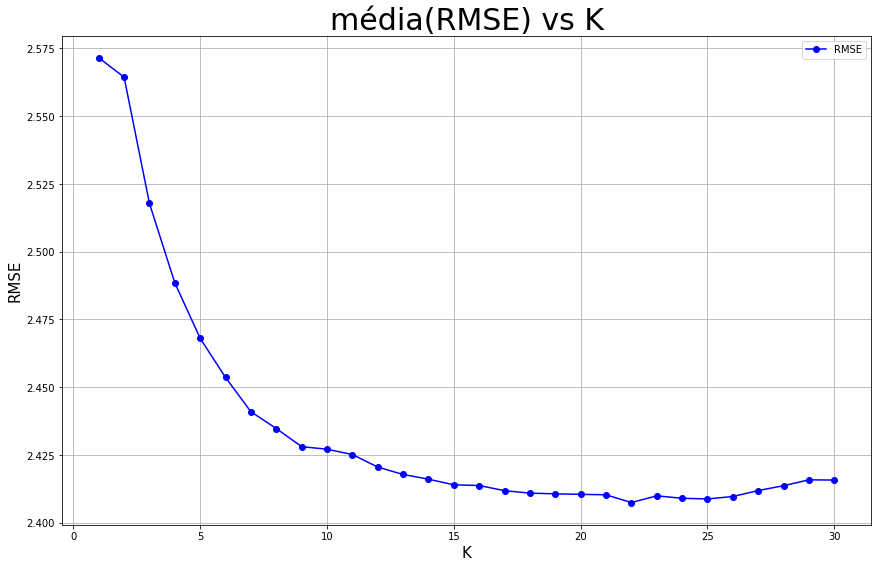

In [23]:
plt.figure(figsize = (14.5, 9))
plt.plot(range(1,31,1), medias_rmse, color = "blue", label = "RMSE", marker = "o")
plt.title ("média(RMSE) vs K", fontsize = 30)
plt.xlabel("K", fontsize = 15)
plt.ylabel("RMSE", fontsize = 15)
plt.grid()
plt.legend()

# Amostras de teste temporal e respectivas estimativas
- A curva acima mostra um ponto mínimo para K = 22 dias passados. Desta forma, podemos aplicar o modelo para as amostras de teste utilizando K = 22 dias passados
- Dados para treinamento: 1981 - 1989
- Dados para teste: 1990

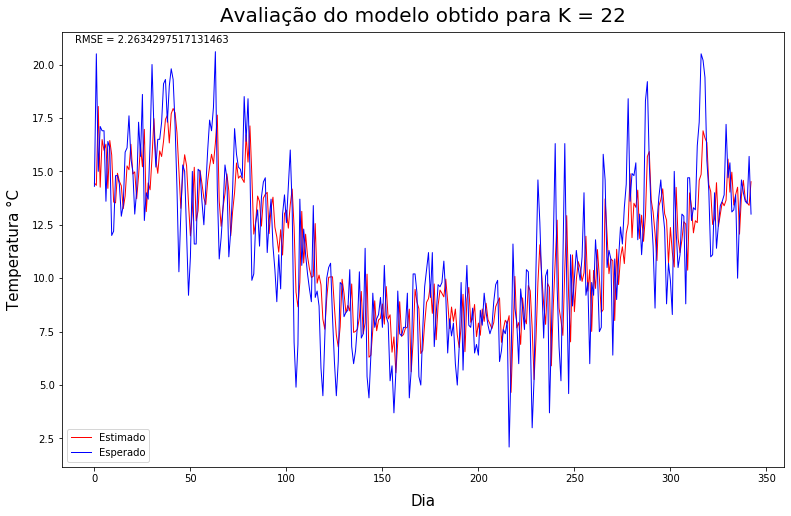

In [24]:
# separa o dataset de 1980 até 1989 como treinamento com n = 22 (que se mostrou como melhor hiper-parâmetro)
folders = kfold_n(data = df, K = 10, n = 22)
training = phi_y(data =pd.concat([    folders[0],\
                                      folders[1],\
                                      folders[2],\
                                      folders[3],\
                                      folders[4],\
                                      folders[5],\
                                      folders[6],\
                                      folders[7],\
                                      folders[8]])\
                 ,n = 22)

test = phi_y(data = folders[9], n = 22)

# Obtém o modelo para os dados de treinamento
W = fit_reg_lin(X = training[0], Y = training[1], add_ones = 1)

# calcula as saídas estimadas com o modelo acima, comparando-as com as saídas esperadas
test[0] = np.c_[np.ones(len(test[0])), test[0]]
y_estimated = test[0].dot(W)
RMSE = float(rmse(y_estimated, test[1]))

# plotando das saídas reais e estimadas do melhor modelo encontrado
plt.figure(figsize = (12.944, 8))
plt.plot(y_estimated, color = "red", label = "Estimado", linewidth = 1)
plt.plot(test[1], color = "blue", label = "Esperado", linewidth = 1)
plt.title("Avaliação do modelo obtido para K = 22", fontsize = 20, pad = 10)
plt.text(x = -10, y = 21, s = "RMSE = " + str(RMSE))
plt.xlabel("Dia", fontsize = 15, labelpad = 10)
plt.ylabel("Temperatura °C", fontsize = 15, labelpad = 10)
plt.legend()

# Parte 2

### Parte 2 - Objetivos
- Para o exercício 2, deve-se, para o mesmo conjunto de dados, explorar um modelo linear de previsão que utiliza como entrada valores obtidos de transformações não-lineares do vetor __x(n)__. Em outras palavras, os atributos que efetivamente são linearmente combinados na predição resultam de mapeamentos não-lineares dos atrasos da série presentes no vetor original __x(n)__. No caso, devem ser gerados T atributos transformados como a seguir:
![mapeamento-nao-linear](./Imagens/mapeamento-nao-linear.png)
- Para k = 1, ..., T e sendo os vetores __Wk__ com componentes gerados aleatoriamente conforme distribuição uniforme
- Além disso, utilizar um esquema de __validação cruzada do tipo k-fold__ juntamente com a técnica de [Ridge Regression](https://towardsdatascience.com/ridge-regression-for-better-usage-2f19b3a202db) para selecionar o melhor valor de combinação para o par ($\lambda$, T), sendo $\lambda$ o coeficiente de Ridge. Neste caso, devem ser tomadas amostras de 5 dias anteriores para T = 1 ... 100 e os possíveis valores $\lambda$ devem ser buscados iterativamente seguindo uma lógica de busca 
- Como parâmetro de qualidade do modelo preditor, deve-se utilizar o valor __RMSE (root mean squared error)__

In [25]:
# import dos dados
df2 = df.copy()

### Normalização dos dados
- Tendo em vista que os dados passarão por um mapeamento através de uma função não-linear do tipo $tanh()$, é importante garantir que os dados sejam normalizados para que seus valores (após a aplicação da função não-linear)
não fiquem concentrados nos pontos de saturação
- Neste sentido, foi criada uma nova coluna de dados de temperatura cujos valores máximos e mínimos não ultrapassem respectivamente os valores de 0.5 e - 0.5. Tais valores foram escolhidos pois a $tanh()$, quando avaliada neste intervalo, mantém sua saída em uma região linear. Conforme mostra a imagem a seguir:
![tanh](./Imagens/tanh-intervalo.png)

In [26]:
# Mapeamento linear do tipo:
# x' = x/(max - min) - min/(max - min)

feature_scale = lambda x:(x/(df2["Temp"].max() - df2["Temp"].min())\
                          - df2["Temp"].min()/(df2["Temp"].max() - df2["Temp"].min()))

In [27]:
df2["Temp_scaled"] = df2["Temp"].apply(feature_scale)
df2["Temp_scaled"] = df2["Temp_scaled"]-0.5
df2["Temp_scaled"] = df2["Temp_scaled"]*1
df2.describe()

,Temp,Temp_scaled
count,3650.000000,3650.000000
mean,11.177753,-0.074990
std,4.071837,0.154823
min,0.000000,-0.500000
25%,8.300000,-0.184411
50%,11.000000,-0.081749
75%,14.000000,0.032319
max,26.300000,0.500000


In [28]:
# pre-visualização dos dados escalados
df2.head(10)

,Date,Temp,Temp_scaled
0,1981-01-01,20.7,0.287072
1,1981-01-02,17.9,0.180608
2,1981-01-03,18.8,0.214829
3,1981-01-04,14.6,0.055133
4,1981-01-05,15.8,0.100760
5,1981-01-06,15.8,0.100760
6,1981-01-07,15.8,0.100760
7,1981-01-08,17.4,0.161597
8,1981-01-09,21.8,0.328897
9,1981-01-10,20.0,0.260456


In [29]:
def rmse(y, y_est):
    ''' Esta função retorna a raíz
        da somatória do erro quadrático médio entre dois vetores (y e y_est de entrada)'''
    sum = 0
    if len(y) != len(y_est):
        return -1
    
    for i in range(len(y)):
        error = (y[i] - y_est[i]) ** 2
        sum += error
        
    return np.sqrt(sum/len(y))

In [30]:
def rmse_shifted(y_est, y):
    sum = 0
    for i in range(len(y)):
        if i == (len(y)-1):
            error = (y[i] - y_est[i])**2
        else:
            error = (y[i] - y_est[i+1])**2
        sum += error
    return sum/(len(y))

In [31]:
def phi_y(data_phi, data_y, n = 1):
    '''
    Esta função gera a matriz Phi e a matriz Y, a partir do dataset data, considerando n dias anteriores
    Retorno:
    Uma lista de 2 elementos, sendo o primeiro elemento a matriz Phi, e o segundo elemento a matriz Y
    '''
    Phi = np.zeros((len(data_y) - n, n))
    Y = np.zeros((len(data_y) - n, 1))
    for i in range(len(data_y) - n):
        Phi[i] = data_phi[i : i+n]
        Y[i] = data_y[i+n]

    return [Phi, Y]

### Pseudo-inversa com fator de regularização $\lambda$ - Ridge Regression
- A função abaixo retorna a matriz de pesos __W__ a partir do conjunto de dados __$\pmb\phi$__ e do conjunto de dados target __Y__, seguindo a solução ótima fechada (pseudo inversa) com fator de regularização Ridge $\lambda$ como a seguir:
![pseudo-inversa-com-ridge](./Imagens/pseudo-inversa-com-ridge.png)
![I_](./Imagens/I_.png)

In [32]:
def fit_reg_lin_lambda(X, Y, alpha = 0, add_ones = False):
    '''
    Função que gera um modelo de Regressão Linear baseado solução fechada (pseudo inversa) do tipo 
    y' = w0 + w1*X1 + ... + wk*Xk, a partir de um vetor de amostras X (dados) e Y (target)
    Com restrição de magnitude dos coeficientes a partir do parâmetro Alpha (Ridge Regression)
    output: [w0, w1, ..., wn]
    '''
    # phi matrix - add a column of 1's for w0 weight
    if add_ones:
        phi = np.c_[np.ones(len(X)), X]
    else:
        phi = X

    # Y matrix    
    Y = np.matrix(Y).reshape((len(Y), 1))
    
    # I' matrix
    I = np.identity(phi.shape[1])
    I[0,0] = 0
    
    #print ("Phi shape: ", phi.shape, "I shape: ", I.shape, "Y shape: ", Y.shape)
    # calculate w = (phi.T * phi)-¹ * phi.T * Y, where * is matrix product
    return (np.linalg.inv(phi.T.dot(phi) + alpha*I).dot(phi.T).dot(Y))

In [33]:
def kfold_n(data = pd.DataFrame(), K = 2, n = 1):
    '''
    Esta função divide o dataset em K pastas para serem treinados com n dias anteriores
    Data: dataset a ser dividido
    K: número de pastas
    n: número de dias corridos
    Retorno:
    Uma lista de K elementos em que cada elemento é a k-ésima pasta
    Retorna as k-1 pastas para treinamento, e a pasta para validação
    '''
    if (K == 1):
        print ("K must be > 1")
        return -1
        
    number_elements = round(len(data)/K)
    folders_phi = list(range(K))
    folders_y = list(range(K))
    
    for i in range(K):
        # Limita o range da última pasta, pois não há dados futuros
        if (i == K-1):
            folders_phi[i] = data.iloc[number_elements*i : number_elements*(i + 1) + n, :]["Temp_scaled"].values
            folders_y[i] = data.iloc[number_elements*i : number_elements*(i + 1) + n, :]["Temp"].values
        else:
            folders_phi[i] = data.iloc[number_elements*i : number_elements*(i + 1) + n, :]["Temp_scaled"].values
            folders_y[i] = data.iloc[number_elements*i : number_elements*(i + 1) + n, :]["Temp"].values
    
    return [folders_phi, folders_y]

# Validação cruzada com K-fold
- novamente, segmentando o dataset em K = 9 pastas devido à periodicidade anual
- considerando 5 dias de atraso
- e realizando K experiências de aprendizagem, conforme abaixo:
![K-folds](./Imagens/k-folds.png)

In [34]:
# treinamento/validação
folders_phi, folders_y = kfold_n(data = df2.iloc[0:len(df2)-365, :], K = 9, n = 5)

# fold 0
fold_phi_0 = np.concatenate([folders_phi[0],\
                             folders_phi[1],\
                             folders_phi[2],\
                             folders_phi[3],\
                             folders_phi[4],\
                             folders_phi[5],\
                             folders_phi[6],\
                             folders_phi[7]])
train_phi_0 = folders_phi[8]
fold_y_0 = np.concatenate([folders_y[0],\
                           folders_y[1],\
                           folders_y[2],\
                           folders_y[3],\
                           folders_y[4],\
                           folders_y[5],\
                           folders_y[6],\
                           folders_y[7]])
train_y_0 = folders_y[8]

# fold 1
fold_phi_1 = np.concatenate([folders_phi[0],\
                             folders_phi[1],\
                             folders_phi[2],\
                             folders_phi[3],\
                             folders_phi[4],\
                             folders_phi[5],\
                             folders_phi[6],\
                             folders_phi[8]])
train_phi_1 = folders_phi[7]
fold_y_1 = np.concatenate([folders_y[0],\
                           folders_y[1],\
                           folders_y[2],\
                           folders_y[3],\
                           folders_y[4],\
                           folders_y[5],\
                           folders_y[6],\
                           folders_y[8]])
train_y_1 = folders_y[7]

# fold 2
fold_phi_2 = np.concatenate([folders_phi[0],\
                             folders_phi[1],\
                             folders_phi[2],\
                             folders_phi[3],\
                             folders_phi[4],\
                             folders_phi[5],\
                             folders_phi[7],\
                             folders_phi[8]])
train_phi_2 = folders_phi[6]
fold_y_2 = np.concatenate([folders_y[0],\
                           folders_y[1],\
                           folders_y[2],\
                           folders_y[3],\
                           folders_y[4],\
                           folders_y[5],\
                           folders_y[7],\
                           folders_y[8]])
train_y_2 = folders_y[6]

# fold 3
fold_phi_3 = np.concatenate([folders_phi[0],\
                             folders_phi[1],\
                             folders_phi[2],\
                             folders_phi[3],\
                             folders_phi[4],\
                             folders_phi[6],\
                             folders_phi[7],\
                             folders_phi[8]])
train_phi_3 = folders_phi[5]
fold_y_3 = np.concatenate([folders_y[0],\
                           folders_y[1],\
                           folders_y[2],\
                           folders_y[3],\
                           folders_y[4],\
                           folders_y[6],\
                           folders_y[7],\
                           folders_y[8]])
train_y_3 = folders_y[5]

# fold 4
fold_phi_4 = np.concatenate([folders_phi[0],\
                             folders_phi[1],\
                             folders_phi[2],\
                             folders_phi[3],\
                             folders_phi[5],\
                             folders_phi[6],\
                             folders_phi[7],\
                             folders_phi[8]])
train_phi_4 = folders_phi[4]
fold_y_4 = np.concatenate([folders_y[0],\
                           folders_y[1],\
                           folders_y[2],\
                           folders_y[3],\
                           folders_y[5],\
                           folders_y[6],\
                           folders_y[7],\
                           folders_y[8]])
train_y_4 = folders_y[4]

# fold 5
fold_phi_5 = np.concatenate([folders_phi[0],\
                             folders_phi[1],\
                             folders_phi[2],\
                             folders_phi[4],\
                             folders_phi[5],\
                             folders_phi[6],\
                             folders_phi[7],\
                             folders_phi[8]])
train_phi_5 = folders_phi[3]
fold_y_5 = np.concatenate([folders_y[0],\
                           folders_y[1],\
                           folders_y[2],\
                           folders_y[4],\
                           folders_y[5],\
                           folders_y[6],\
                           folders_y[7],\
                           folders_y[8]])
train_y_5 = folders_y[3]

# fold 6
fold_phi_6 = np.concatenate([folders_phi[0],\
                             folders_phi[1],\
                             folders_phi[3],\
                             folders_phi[4],\
                             folders_phi[5],\
                             folders_phi[6],\
                             folders_phi[7],\
                             folders_phi[8]])
train_phi_6 = folders_phi[2]
fold_y_6 = np.concatenate([folders_y[0],\
                           folders_y[1],\
                           folders_y[3],\
                           folders_y[4],\
                           folders_y[5],\
                           folders_y[6],\
                           folders_y[7],\
                           folders_y[8]])
train_y_6 = folders_y[2]

# fold 7
fold_phi_7 = np.concatenate([folders_phi[0],\
                             folders_phi[2],\
                             folders_phi[3],\
                             folders_phi[4],\
                             folders_phi[5],\
                             folders_phi[6],\
                             folders_phi[7],\
                             folders_phi[8]])
train_phi_7 = folders_phi[1]
fold_y_7 = np.concatenate([folders_y[0],\
                           folders_y[2],\
                           folders_y[3],\
                           folders_y[4],\
                           folders_y[5],\
                           folders_y[6],\
                           folders_y[7],\
                           folders_y[8]])
train_y_7 = folders_y[1]

# fold 8
fold_phi_8 = np.concatenate([folders_phi[1],\
                             folders_phi[2],\
                             folders_phi[3],\
                             folders_phi[4],\
                             folders_phi[5],\
                             folders_phi[6],\
                             folders_phi[7],\
                             folders_phi[8]])
train_phi_8 = folders_phi[0]
fold_y_8 = np.concatenate([folders_y[1],\
                           folders_y[2],\
                           folders_y[3],\
                           folders_y[4],\
                           folders_y[5],\
                           folders_y[6],\
                           folders_y[7],\
                           folders_y[8]])
train_y_8 = folders_y[0]


fold_phi = [fold_phi_0, fold_phi_1, fold_phi_2, fold_phi_3, fold_phi_4,\
            fold_phi_5, fold_phi_6, fold_phi_7, fold_phi_8]
train_phi = [train_phi_0, train_phi_1, train_phi_2, train_phi_3, train_phi_4,\
             train_phi_5, train_phi_6, train_phi_7, train_phi_8]
fold_y = [fold_y_0, fold_y_1, fold_y_2, fold_y_3, fold_y_4,\
          fold_y_5, fold_y_6, fold_y_7, fold_y_8]
train_y = [train_y_0, train_y_1, train_y_2, train_y_3, train_y_4,\
           train_y_5, train_y_6, train_y_7, train_y_8]


# Treinamento
- O código a seguir realiza o treinamento do modelo, percorrendo os 100 valores sugeridos de atributos para cada $\lambda$ e então avaliados para cada pasta do k-fold
    - Para cada atributo, gera-se um novo vetor __W__ com pesos aleatórios seguindo uma distribuição uniforme com faixa de valores entre 0 e 1. O
        - Para cada $\lambda$, varre-se as 9 pastas
            - Para cada pasta, avalia-se o modelo para o dado de treinamento e validação
- __OBS__:
- A faixa de valores do vetor $W_k$ foi escolhida de forma que as amostras, após o resultado do produto vetorial $W_k\cdot X_k$, se concetrassem nos valores -1 a 1 para que a $tanh()$ não levasse as amostras para pontos de saturação. A figura abaixo mostra 100 amostras aleatórias do produto vetorial entre $W_k$ com valores entre 0 e 1 e $Y$ com valores entre -0.5 e 0.5.
![wk-xk](./Imagens/wk-xk.png)
- A faixa de valores de $\lambda$ é gerada a partir de uma busca com potências de 2, começando em valores baixos. Seguindo a dica do Professor Romis.

In [35]:
# para cada T
    # varrer lambda
        # obtém o modelo e avalia-se para cada K (k-fold)
import datetime

T = 100
Alpha = [np.power(2, i) for i in np.arange(-11, 2, step = 2, dtype = float)]
RMSEs = []
progress = 0
print(T*len(Alpha)*len(fold_phi))


for t in range(0,T):
    W = np.array([[np.random.uniform(0, 1) for i in range(5)] for i in range(t+1)])
    for alpha in Alpha:
        for i in range(len(fold_phi)):
            # gera Phi de treinamento
            data_phi = fold_phi[i]
            data_y = fold_y[i]
            X_5days, Y_5days = phi_y(data_phi, data_y, n = 5)            
            Phi = np.zeros(shape = (len(Y_5days), t+1))
            
            for row in range(Phi.shape[0]):
                for column in range(Phi.shape[1]):
                    Phi[row][column] = W[column].dot(X_5days[row])
            Phi = np.tanh(Phi)
            
            # treina o modelo com Ridge Regression
            model_t_alpha_k =\
            fit_reg_lin_lambda(X = Phi[:, 0:t+1], Y = Y_5days, alpha = alpha, add_ones = True)

            # gera Phi de validação            
            data_phi = train_phi[i]
            data_y = train_y[i]            
            X_Validation_5days, Y_Validation_5days = phi_y(data_phi, data_y, n = 5) 
            Phi_Validation = np.zeros(shape = (len(Y_Validation_5days), t+1))
            
            for row in range(Phi_Validation.shape[0]):
                for column in range(Phi_Validation.shape[1]):
                    Phi_Validation[row][column] = W[column].dot(X_Validation_5days[row])
            Phi_Validation = np.tanh(Phi_Validation)
            Phi_Validation = np.c_[np.ones(len(Phi_Validation)), Phi_Validation]
            
            # calcula saídas esperadas e erro rmse para a saída gerada
            y_estimated = Phi_Validation[:, 0:t+2].dot(model_t_alpha_k)            
            RMSE = float(rmse(y_estimated, Y_Validation_5days))
            RMSEs.append([i, alpha, t, RMSE])
            
            # prints
            progress += 1
            if progress%100 == 0:
                print ("progress: ", progress)
                print(datetime.datetime.now())
            
            print("t: ", str(t), "alpha: ", str(alpha), "K: ", str(i), "RMSE: ", RMSE)
            

6300
t:  0 alpha:  0.00048828125 K:  0 RMSE:  2.8462093856314135
t:  0 alpha:  0.00048828125 K:  1 RMSE:  3.0054947046486435
t:  0 alpha:  0.00048828125 K:  2 RMSE:  3.1379240260886645
t:  0 alpha:  0.00048828125 K:  3 RMSE:  2.8189902002949703
t:  0 alpha:  0.00048828125 K:  4 RMSE:  3.0001745329150653
t:  0 alpha:  0.00048828125 K:  5 RMSE:  2.9653434050800502
t:  0 alpha:  0.00048828125 K:  6 RMSE:  3.1193537273533583
t:  0 alpha:  0.00048828125 K:  7 RMSE:  3.5319888256012124
t:  0 alpha:  0.00048828125 K:  8 RMSE:  2.9529632128814036
t:  0 alpha:  0.001953125 K:  0 RMSE:  2.8462115642703703
t:  0 alpha:  0.001953125 K:  1 RMSE:  3.0054938136572353
t:  0 alpha:  0.001953125 K:  2 RMSE:  3.1379213228021574
t:  0 alpha:  0.001953125 K:  3 RMSE:  2.818989925030809
t:  0 alpha:  0.001953125 K:  4 RMSE:  3.0001747864194384
t:  0 alpha:  0.001953125 K:  5 RMSE:  2.9653426246514747
t:  0 alpha:  0.001953125 K:  6 RMSE:  3.1193537752546563
t:  0 alpha:  0.001953125 K:  7 RMSE:  3.531989723

t:  2 alpha:  0.03125 K:  4 RMSE:  2.5518711312791442
t:  2 alpha:  0.03125 K:  5 RMSE:  2.701415170075132
t:  2 alpha:  0.03125 K:  6 RMSE:  2.6801758650937852
t:  2 alpha:  0.03125 K:  7 RMSE:  3.0206649886324506
t:  2 alpha:  0.03125 K:  8 RMSE:  2.5907343076357296
t:  2 alpha:  0.125 K:  0 RMSE:  2.375473164119864
t:  2 alpha:  0.125 K:  1 RMSE:  2.6708910972781474
t:  2 alpha:  0.125 K:  2 RMSE:  2.6536041584866394
t:  2 alpha:  0.125 K:  3 RMSE:  2.548980594338985
t:  2 alpha:  0.125 K:  4 RMSE:  2.5533846514334995
t:  2 alpha:  0.125 K:  5 RMSE:  2.7011267484109083
t:  2 alpha:  0.125 K:  6 RMSE:  2.6838411770766935
t:  2 alpha:  0.125 K:  7 RMSE:  3.0224449724221434
t:  2 alpha:  0.125 K:  8 RMSE:  2.589865279166658
t:  2 alpha:  0.5 K:  0 RMSE:  2.3804980100793767
t:  2 alpha:  0.5 K:  1 RMSE:  2.672390699190516
t:  2 alpha:  0.5 K:  2 RMSE:  2.656163538070834
t:  2 alpha:  0.5 K:  3 RMSE:  2.5537845164079793
t:  2 alpha:  0.5 K:  4 RMSE:  2.5580160648041534
t:  2 alpha:  0.5 

t:  4 alpha:  2.0 K:  6 RMSE:  2.561456803036729
t:  4 alpha:  2.0 K:  7 RMSE:  2.8087193443552874
t:  4 alpha:  2.0 K:  8 RMSE:  2.470458095599072
t:  5 alpha:  0.00048828125 K:  0 RMSE:  2.3813503905358844
t:  5 alpha:  0.00048828125 K:  1 RMSE:  2.6007366578528477
t:  5 alpha:  0.00048828125 K:  2 RMSE:  2.680124046771069
t:  5 alpha:  0.00048828125 K:  3 RMSE:  2.5829252328435137
t:  5 alpha:  0.00048828125 K:  4 RMSE:  2.5490745086793503
t:  5 alpha:  0.00048828125 K:  5 RMSE:  2.644334926220219
t:  5 alpha:  0.00048828125 K:  6 RMSE:  2.652254594518391
t:  5 alpha:  0.00048828125 K:  7 RMSE:  3.086490703431703
t:  5 alpha:  0.00048828125 K:  8 RMSE:  2.4885434005300113
t:  5 alpha:  0.001953125 K:  0 RMSE:  2.3812420576139663
t:  5 alpha:  0.001953125 K:  1 RMSE:  2.5977117781479375
t:  5 alpha:  0.001953125 K:  2 RMSE:  2.6809721871892283
t:  5 alpha:  0.001953125 K:  3 RMSE:  2.583569566517278
t:  5 alpha:  0.001953125 K:  4 RMSE:  2.54909837995591
t:  5 alpha:  0.001953125 K: 

t:  7 alpha:  0.0078125 K:  4 RMSE:  2.405526014221014
t:  7 alpha:  0.0078125 K:  5 RMSE:  2.555257032918491
t:  7 alpha:  0.0078125 K:  6 RMSE:  2.529618943763383
t:  7 alpha:  0.0078125 K:  7 RMSE:  2.805069561593537
t:  7 alpha:  0.0078125 K:  8 RMSE:  2.44550126831744
t:  7 alpha:  0.03125 K:  0 RMSE:  2.2140630062305773
t:  7 alpha:  0.03125 K:  1 RMSE:  2.49045300846685
t:  7 alpha:  0.03125 K:  2 RMSE:  2.4755691385325673
t:  7 alpha:  0.03125 K:  3 RMSE:  2.493976483533107
t:  7 alpha:  0.03125 K:  4 RMSE:  2.407133453448111
t:  7 alpha:  0.03125 K:  5 RMSE:  2.5615903457420686
t:  7 alpha:  0.03125 K:  6 RMSE:  2.531998671257128
t:  7 alpha:  0.03125 K:  7 RMSE:  2.807126835427026
t:  7 alpha:  0.03125 K:  8 RMSE:  2.4522153653716976
t:  7 alpha:  0.125 K:  0 RMSE:  2.221338320225476
t:  7 alpha:  0.125 K:  1 RMSE:  2.497097908099551
t:  7 alpha:  0.125 K:  2 RMSE:  2.48095519489177
t:  7 alpha:  0.125 K:  3 RMSE:  2.4951184571883886
t:  7 alpha:  0.125 K:  4 RMSE:  2.4107218

t:  9 alpha:  0.5 K:  6 RMSE:  2.545569661815046
t:  9 alpha:  0.5 K:  7 RMSE:  2.803593928738613
t:  9 alpha:  0.5 K:  8 RMSE:  2.445330551670808
t:  9 alpha:  2.0 K:  0 RMSE:  2.2388837315615895
t:  9 alpha:  2.0 K:  1 RMSE:  2.5036996648237144
t:  9 alpha:  2.0 K:  2 RMSE:  2.4977020911975365
t:  9 alpha:  2.0 K:  3 RMSE:  2.4720143339847938
t:  9 alpha:  2.0 K:  4 RMSE:  2.4354888744756
t:  9 alpha:  2.0 K:  5 RMSE:  2.554274954269487
t:  9 alpha:  2.0 K:  6 RMSE:  2.5661497974920997
t:  9 alpha:  2.0 K:  7 RMSE:  2.844438583043944
t:  9 alpha:  2.0 K:  8 RMSE:  2.451064389101792
t:  10 alpha:  0.00048828125 K:  0 RMSE:  2.2021723565311278
t:  10 alpha:  0.00048828125 K:  1 RMSE:  2.492513284217671
t:  10 alpha:  0.00048828125 K:  2 RMSE:  2.478799163800205
t:  10 alpha:  0.00048828125 K:  3 RMSE:  2.4759105572224627
t:  10 alpha:  0.00048828125 K:  4 RMSE:  2.418075478435798
t:  10 alpha:  0.00048828125 K:  5 RMSE:  2.520326381486867
t:  10 alpha:  0.00048828125 K:  6 RMSE:  2.528

t:  12 alpha:  0.001953125 K:  4 RMSE:  2.4151140142499763
t:  12 alpha:  0.001953125 K:  5 RMSE:  2.522404017895539
t:  12 alpha:  0.001953125 K:  6 RMSE:  2.53613011683992
t:  12 alpha:  0.001953125 K:  7 RMSE:  2.7857780061211237
t:  12 alpha:  0.001953125 K:  8 RMSE:  2.4212219103197303
t:  12 alpha:  0.0078125 K:  0 RMSE:  2.2019143615431522
t:  12 alpha:  0.0078125 K:  1 RMSE:  2.4854791211740905
t:  12 alpha:  0.0078125 K:  2 RMSE:  2.4708584826081776
t:  12 alpha:  0.0078125 K:  3 RMSE:  2.4771898183699865
t:  12 alpha:  0.0078125 K:  4 RMSE:  2.415971806615525
t:  12 alpha:  0.0078125 K:  5 RMSE:  2.528432456294345
t:  12 alpha:  0.0078125 K:  6 RMSE:  2.5326908528823426
t:  12 alpha:  0.0078125 K:  7 RMSE:  2.7792890392606973
t:  12 alpha:  0.0078125 K:  8 RMSE:  2.4254582507262583
t:  12 alpha:  0.03125 K:  0 RMSE:  2.2036886295308324
t:  12 alpha:  0.03125 K:  1 RMSE:  2.4854379382796363
t:  12 alpha:  0.03125 K:  2 RMSE:  2.470280683285724
t:  12 alpha:  0.03125 K:  3 RMSE

t:  14 alpha:  0.125 K:  1 RMSE:  2.492647258986434
t:  14 alpha:  0.125 K:  2 RMSE:  2.4778082178630974
t:  14 alpha:  0.125 K:  3 RMSE:  2.481512604321013
t:  14 alpha:  0.125 K:  4 RMSE:  2.415654039846555
t:  14 alpha:  0.125 K:  5 RMSE:  2.539547478837598
t:  14 alpha:  0.125 K:  6 RMSE:  2.5333011353835277
t:  14 alpha:  0.125 K:  7 RMSE:  2.7811679422365527
t:  14 alpha:  0.125 K:  8 RMSE:  2.4389402734583294
t:  14 alpha:  0.5 K:  0 RMSE:  2.214964214234964
t:  14 alpha:  0.5 K:  1 RMSE:  2.488135696550989
t:  14 alpha:  0.5 K:  2 RMSE:  2.4805106474366374
t:  14 alpha:  0.5 K:  3 RMSE:  2.4860340693443574
t:  14 alpha:  0.5 K:  4 RMSE:  2.4187380433099075
t:  14 alpha:  0.5 K:  5 RMSE:  2.542921409440161
t:  14 alpha:  0.5 K:  6 RMSE:  2.5401157129647105
t:  14 alpha:  0.5 K:  7 RMSE:  2.8003341583106818
t:  14 alpha:  0.5 K:  8 RMSE:  2.4401834293256797
t:  14 alpha:  2.0 K:  0 RMSE:  2.236287111653016
t:  14 alpha:  2.0 K:  1 RMSE:  2.4895962061565253
t:  14 alpha:  2.0 K:  

t:  17 alpha:  0.00048828125 K:  1 RMSE:  2.4826664353347025
t:  17 alpha:  0.00048828125 K:  2 RMSE:  2.4900269943934434
t:  17 alpha:  0.00048828125 K:  3 RMSE:  2.466560663105435
t:  17 alpha:  0.00048828125 K:  4 RMSE:  2.4121434486570092
t:  17 alpha:  0.00048828125 K:  5 RMSE:  2.5208049855413
t:  17 alpha:  0.00048828125 K:  6 RMSE:  2.5208582361818577
t:  17 alpha:  0.00048828125 K:  7 RMSE:  2.784644385731053
t:  17 alpha:  0.00048828125 K:  8 RMSE:  2.4225739076839337
t:  17 alpha:  0.001953125 K:  0 RMSE:  2.2081969630624396
t:  17 alpha:  0.001953125 K:  1 RMSE:  2.483047102473747
t:  17 alpha:  0.001953125 K:  2 RMSE:  2.486786704984567
t:  17 alpha:  0.001953125 K:  3 RMSE:  2.4722933152261035
t:  17 alpha:  0.001953125 K:  4 RMSE:  2.4139862681764663
t:  17 alpha:  0.001953125 K:  5 RMSE:  2.524221478846726
t:  17 alpha:  0.001953125 K:  6 RMSE:  2.52119393299297
t:  17 alpha:  0.001953125 K:  7 RMSE:  2.7808454843884514
t:  17 alpha:  0.001953125 K:  8 RMSE:  2.42318914

t:  19 alpha:  0.0078125 K:  4 RMSE:  2.4161185407503676
t:  19 alpha:  0.0078125 K:  5 RMSE:  2.5174222906797383
t:  19 alpha:  0.0078125 K:  6 RMSE:  2.5231728095666877
t:  19 alpha:  0.0078125 K:  7 RMSE:  2.790441786456992
t:  19 alpha:  0.0078125 K:  8 RMSE:  2.421073029008696
t:  19 alpha:  0.03125 K:  0 RMSE:  2.199013517521258
t:  19 alpha:  0.03125 K:  1 RMSE:  2.490626003064079
t:  19 alpha:  0.03125 K:  2 RMSE:  2.479809607301771
t:  19 alpha:  0.03125 K:  3 RMSE:  2.475467384395489
t:  19 alpha:  0.03125 K:  4 RMSE:  2.4153729407885436
t:  19 alpha:  0.03125 K:  5 RMSE:  2.5276061305089765
t:  19 alpha:  0.03125 K:  6 RMSE:  2.5275920663579052
t:  19 alpha:  0.03125 K:  7 RMSE:  2.785280248226944
t:  19 alpha:  0.03125 K:  8 RMSE:  2.423537057663979
t:  19 alpha:  0.125 K:  0 RMSE:  2.202124242876882
t:  19 alpha:  0.125 K:  1 RMSE:  2.4899185798588164
t:  19 alpha:  0.125 K:  2 RMSE:  2.474168054177922
t:  19 alpha:  0.125 K:  3 RMSE:  2.4811924265124556
t:  19 alpha:  0.1

t:  21 alpha:  0.5 K:  1 RMSE:  2.491171838548669
t:  21 alpha:  0.5 K:  2 RMSE:  2.4721835992847154
t:  21 alpha:  0.5 K:  3 RMSE:  2.484956758329757
t:  21 alpha:  0.5 K:  4 RMSE:  2.4115350582682282
t:  21 alpha:  0.5 K:  5 RMSE:  2.54574934582581
t:  21 alpha:  0.5 K:  6 RMSE:  2.5342565868716465
t:  21 alpha:  0.5 K:  7 RMSE:  2.7898250678437195
t:  21 alpha:  0.5 K:  8 RMSE:  2.4416968167155915
t:  21 alpha:  2.0 K:  0 RMSE:  2.2148423589354316
t:  21 alpha:  2.0 K:  1 RMSE:  2.4888677253883564
t:  21 alpha:  2.0 K:  2 RMSE:  2.482859334802296
t:  21 alpha:  2.0 K:  3 RMSE:  2.4825063033595574
t:  21 alpha:  2.0 K:  4 RMSE:  2.417384126561705
t:  21 alpha:  2.0 K:  5 RMSE:  2.5422702096111314
t:  21 alpha:  2.0 K:  6 RMSE:  2.5379632137211687
t:  21 alpha:  2.0 K:  7 RMSE:  2.802974175757102
t:  21 alpha:  2.0 K:  8 RMSE:  2.4394167614240803
t:  22 alpha:  0.00048828125 K:  0 RMSE:  2.203016530381666
t:  22 alpha:  0.00048828125 K:  1 RMSE:  2.4833202660022105
t:  22 alpha:  0.00

t:  24 alpha:  0.00048828125 K:  7 RMSE:  2.7995254661379763
t:  24 alpha:  0.00048828125 K:  8 RMSE:  2.430690663243664
t:  24 alpha:  0.001953125 K:  0 RMSE:  2.205454893064191
t:  24 alpha:  0.001953125 K:  1 RMSE:  2.4851510214828165
t:  24 alpha:  0.001953125 K:  2 RMSE:  2.490622887149655
t:  24 alpha:  0.001953125 K:  3 RMSE:  2.4670858704917733
t:  24 alpha:  0.001953125 K:  4 RMSE:  2.41626325349756
t:  24 alpha:  0.001953125 K:  5 RMSE:  2.5174076816290714
t:  24 alpha:  0.001953125 K:  6 RMSE:  2.522680449029826
t:  24 alpha:  0.001953125 K:  7 RMSE:  2.7882813284192176
t:  24 alpha:  0.001953125 K:  8 RMSE:  2.4316652685403586
t:  24 alpha:  0.0078125 K:  0 RMSE:  2.2065117725529944
t:  24 alpha:  0.0078125 K:  1 RMSE:  2.483152573938744
t:  24 alpha:  0.0078125 K:  2 RMSE:  2.4842407428343893
t:  24 alpha:  0.0078125 K:  3 RMSE:  2.471516113882705
t:  24 alpha:  0.0078125 K:  4 RMSE:  2.4161324906434865
t:  24 alpha:  0.0078125 K:  5 RMSE:  2.5250657972210186
t:  24 alpha:

t:  26 alpha:  0.03125 K:  2 RMSE:  2.477448101572503
t:  26 alpha:  0.03125 K:  3 RMSE:  2.471716452623186
t:  26 alpha:  0.03125 K:  4 RMSE:  2.415650281432456
t:  26 alpha:  0.03125 K:  5 RMSE:  2.524687870094558
t:  26 alpha:  0.03125 K:  6 RMSE:  2.5236045596720893
t:  26 alpha:  0.03125 K:  7 RMSE:  2.7775942106324374
t:  26 alpha:  0.03125 K:  8 RMSE:  2.4227226257078067
t:  26 alpha:  0.125 K:  0 RMSE:  2.2036041850556733
t:  26 alpha:  0.125 K:  1 RMSE:  2.4881068281892236
t:  26 alpha:  0.125 K:  2 RMSE:  2.4711509759642856
t:  26 alpha:  0.125 K:  3 RMSE:  2.47753953293979
t:  26 alpha:  0.125 K:  4 RMSE:  2.4139631593337603
t:  26 alpha:  0.125 K:  5 RMSE:  2.5370392068222576
t:  26 alpha:  0.125 K:  6 RMSE:  2.5285276699591295
t:  26 alpha:  0.125 K:  7 RMSE:  2.7784760559656005
t:  26 alpha:  0.125 K:  8 RMSE:  2.4312565459095627
t:  26 alpha:  0.5 K:  0 RMSE:  2.2084918721824836
t:  26 alpha:  0.5 K:  1 RMSE:  2.4908741134890287
t:  26 alpha:  0.5 K:  2 RMSE:  2.46939989

t:  28 alpha:  0.5 K:  8 RMSE:  2.446054510755941
t:  28 alpha:  2.0 K:  0 RMSE:  2.2202467187045265
t:  28 alpha:  2.0 K:  1 RMSE:  2.493662072541885
t:  28 alpha:  2.0 K:  2 RMSE:  2.4826165072436583
t:  28 alpha:  2.0 K:  3 RMSE:  2.489402234033382
t:  28 alpha:  2.0 K:  4 RMSE:  2.4202582292922545
t:  28 alpha:  2.0 K:  5 RMSE:  2.553355510542913
t:  28 alpha:  2.0 K:  6 RMSE:  2.546174506218201
t:  28 alpha:  2.0 K:  7 RMSE:  2.810865847944099
t:  28 alpha:  2.0 K:  8 RMSE:  2.447601440013072
t:  29 alpha:  0.00048828125 K:  0 RMSE:  2.2042803896997287
t:  29 alpha:  0.00048828125 K:  1 RMSE:  2.488518604691774
t:  29 alpha:  0.00048828125 K:  2 RMSE:  2.4844070302645402
t:  29 alpha:  0.00048828125 K:  3 RMSE:  2.4642785229945448
t:  29 alpha:  0.00048828125 K:  4 RMSE:  2.4199073804572255
t:  29 alpha:  0.00048828125 K:  5 RMSE:  2.5127562823450096
t:  29 alpha:  0.00048828125 K:  6 RMSE:  2.5371135123509974
t:  29 alpha:  0.00048828125 K:  7 RMSE:  2.804777703763187
t:  29 alph

t:  31 alpha:  0.001953125 K:  5 RMSE:  2.5103570751682973
t:  31 alpha:  0.001953125 K:  6 RMSE:  2.52000250478692
t:  31 alpha:  0.001953125 K:  7 RMSE:  2.7924586981482724
t:  31 alpha:  0.001953125 K:  8 RMSE:  2.430963370325659
t:  31 alpha:  0.0078125 K:  0 RMSE:  2.200557163071286
t:  31 alpha:  0.0078125 K:  1 RMSE:  2.494656288420766
t:  31 alpha:  0.0078125 K:  2 RMSE:  2.4809642864225085
t:  31 alpha:  0.0078125 K:  3 RMSE:  2.4738508662820786
t:  31 alpha:  0.0078125 K:  4 RMSE:  2.4215187080835787
t:  31 alpha:  0.0078125 K:  5 RMSE:  2.52068370576993
t:  31 alpha:  0.0078125 K:  6 RMSE:  2.524856947942414
t:  31 alpha:  0.0078125 K:  7 RMSE:  2.781822948438328
t:  31 alpha:  0.0078125 K:  8 RMSE:  2.4321767746135423
t:  31 alpha:  0.03125 K:  0 RMSE:  2.203137545243424
t:  31 alpha:  0.03125 K:  1 RMSE:  2.494693451242593
t:  31 alpha:  0.03125 K:  2 RMSE:  2.4745051325677374
t:  31 alpha:  0.03125 K:  3 RMSE:  2.479371678153926
t:  31 alpha:  0.03125 K:  4 RMSE:  2.41950

t:  33 alpha:  0.125 K:  1 RMSE:  2.4878671013480416
t:  33 alpha:  0.125 K:  2 RMSE:  2.4781305883158913
t:  33 alpha:  0.125 K:  3 RMSE:  2.4771646526181854
t:  33 alpha:  0.125 K:  4 RMSE:  2.4095831808912247
t:  33 alpha:  0.125 K:  5 RMSE:  2.529274861564799
t:  33 alpha:  0.125 K:  6 RMSE:  2.52481636581255
t:  33 alpha:  0.125 K:  7 RMSE:  2.782159240394174
t:  33 alpha:  0.125 K:  8 RMSE:  2.427738960824819
t:  33 alpha:  0.5 K:  0 RMSE:  2.205855738868392
t:  33 alpha:  0.5 K:  1 RMSE:  2.491034762507008
t:  33 alpha:  0.5 K:  2 RMSE:  2.474155574541668
t:  33 alpha:  0.5 K:  3 RMSE:  2.4844290963343116
t:  33 alpha:  0.5 K:  4 RMSE:  2.4093907177779457
t:  33 alpha:  0.5 K:  5 RMSE:  2.542654849837402
t:  33 alpha:  0.5 K:  6 RMSE:  2.531514493941121
t:  33 alpha:  0.5 K:  7 RMSE:  2.789864440148823
t:  33 alpha:  0.5 K:  8 RMSE:  2.436174445172997
t:  33 alpha:  2.0 K:  0 RMSE:  2.214215909790876
t:  33 alpha:  2.0 K:  1 RMSE:  2.4927766194710075
t:  33 alpha:  2.0 K:  2 RMS

t:  36 alpha:  0.00048828125 K:  0 RMSE:  2.2007812751383327
t:  36 alpha:  0.00048828125 K:  1 RMSE:  2.4936391141832615
t:  36 alpha:  0.00048828125 K:  2 RMSE:  2.4957868646252774
t:  36 alpha:  0.00048828125 K:  3 RMSE:  2.4643010290528875
t:  36 alpha:  0.00048828125 K:  4 RMSE:  2.416846849600799
t:  36 alpha:  0.00048828125 K:  5 RMSE:  2.5095423531182317
t:  36 alpha:  0.00048828125 K:  6 RMSE:  2.5221797800282184
t:  36 alpha:  0.00048828125 K:  7 RMSE:  2.8093302230904675
t:  36 alpha:  0.00048828125 K:  8 RMSE:  2.426708990608526
t:  36 alpha:  0.001953125 K:  0 RMSE:  2.201862563060388
t:  36 alpha:  0.001953125 K:  1 RMSE:  2.494054410946724
t:  36 alpha:  0.001953125 K:  2 RMSE:  2.493406334285858
t:  36 alpha:  0.001953125 K:  3 RMSE:  2.465927878759894
t:  36 alpha:  0.001953125 K:  4 RMSE:  2.417250127418699
t:  36 alpha:  0.001953125 K:  5 RMSE:  2.5120016662459244
t:  36 alpha:  0.001953125 K:  6 RMSE:  2.5225465873253534
t:  36 alpha:  0.001953125 K:  7 RMSE:  2.799

t:  38 alpha:  0.0078125 K:  3 RMSE:  2.4719667203978157
t:  38 alpha:  0.0078125 K:  4 RMSE:  2.4164046289384684
t:  38 alpha:  0.0078125 K:  5 RMSE:  2.5123475236604116
t:  38 alpha:  0.0078125 K:  6 RMSE:  2.520704272893636
t:  38 alpha:  0.0078125 K:  7 RMSE:  2.790676850464956
t:  38 alpha:  0.0078125 K:  8 RMSE:  2.426763378834939
t:  38 alpha:  0.03125 K:  0 RMSE:  2.20048153549299
t:  38 alpha:  0.03125 K:  1 RMSE:  2.488589666877153
t:  38 alpha:  0.03125 K:  2 RMSE:  2.4835614620372723
t:  38 alpha:  0.03125 K:  3 RMSE:  2.4737729022066057
t:  38 alpha:  0.03125 K:  4 RMSE:  2.414590259243044
t:  38 alpha:  0.03125 K:  5 RMSE:  2.519451652924231
t:  38 alpha:  0.03125 K:  6 RMSE:  2.5222275409941486
t:  38 alpha:  0.03125 K:  7 RMSE:  2.782076745068875
t:  38 alpha:  0.03125 K:  8 RMSE:  2.4274298020789553
t:  38 alpha:  0.125 K:  0 RMSE:  2.2023244426413116
t:  38 alpha:  0.125 K:  1 RMSE:  2.489146238990496
t:  38 alpha:  0.125 K:  2 RMSE:  2.475889232695816
t:  38 alpha:  

t:  40 alpha:  0.125 K:  8 RMSE:  2.4276292087842877
t:  40 alpha:  0.5 K:  0 RMSE:  2.205451592408922
t:  40 alpha:  0.5 K:  1 RMSE:  2.4900761874484547
t:  40 alpha:  0.5 K:  2 RMSE:  2.4756043392604767
t:  40 alpha:  0.5 K:  3 RMSE:  2.4802506272498595
t:  40 alpha:  0.5 K:  4 RMSE:  2.4146473397833925
t:  40 alpha:  0.5 K:  5 RMSE:  2.5414371655184524
t:  40 alpha:  0.5 K:  6 RMSE:  2.5337334487594276
t:  40 alpha:  0.5 K:  7 RMSE:  2.7856499135594515
t:  40 alpha:  0.5 K:  8 RMSE:  2.43312897186445
t:  40 alpha:  2.0 K:  0 RMSE:  2.211438299609911
t:  40 alpha:  2.0 K:  1 RMSE:  2.489734065213804
t:  40 alpha:  2.0 K:  2 RMSE:  2.478129655455738
t:  40 alpha:  2.0 K:  3 RMSE:  2.481251959617672
t:  40 alpha:  2.0 K:  4 RMSE:  2.4151749986700475
t:  40 alpha:  2.0 K:  5 RMSE:  2.543732471056997
t:  40 alpha:  2.0 K:  6 RMSE:  2.537826315790614
t:  40 alpha:  2.0 K:  7 RMSE:  2.79794397606102
t:  40 alpha:  2.0 K:  8 RMSE:  2.4335781792180438
t:  41 alpha:  0.00048828125 K:  0 RMSE:

t:  43 alpha:  0.00048828125 K:  5 RMSE:  2.503792297794491
t:  43 alpha:  0.00048828125 K:  6 RMSE:  2.5222410110802076
t:  43 alpha:  0.00048828125 K:  7 RMSE:  2.815110003446555
t:  43 alpha:  0.00048828125 K:  8 RMSE:  2.429728919351188
t:  43 alpha:  0.001953125 K:  0 RMSE:  2.199274442564314
t:  43 alpha:  0.001953125 K:  1 RMSE:  2.488292022818546
t:  43 alpha:  0.001953125 K:  2 RMSE:  2.4896940637836473
t:  43 alpha:  0.001953125 K:  3 RMSE:  2.4681675514984134
t:  43 alpha:  0.001953125 K:  4 RMSE:  2.41419652406455
t:  43 alpha:  0.001953125 K:  5 RMSE:  2.507669285804124
t:  43 alpha:  0.001953125 K:  6 RMSE:  2.5192693400751525
t:  43 alpha:  0.001953125 K:  7 RMSE:  2.8092053422358023
t:  43 alpha:  0.001953125 K:  8 RMSE:  2.4262192285239226
t:  43 alpha:  0.0078125 K:  0 RMSE:  2.200074825072675
t:  43 alpha:  0.0078125 K:  1 RMSE:  2.4872774817043033
t:  43 alpha:  0.0078125 K:  2 RMSE:  2.488783027555986
t:  43 alpha:  0.0078125 K:  3 RMSE:  2.4710654168613537
t:  43 

t:  45 alpha:  0.03125 K:  0 RMSE:  2.204008930270794
t:  45 alpha:  0.03125 K:  1 RMSE:  2.487373803513737
t:  45 alpha:  0.03125 K:  2 RMSE:  2.4882120247798225
t:  45 alpha:  0.03125 K:  3 RMSE:  2.472723420478369
t:  45 alpha:  0.03125 K:  4 RMSE:  2.4145299835954304
t:  45 alpha:  0.03125 K:  5 RMSE:  2.520723813312278
t:  45 alpha:  0.03125 K:  6 RMSE:  2.5235077310874257
t:  45 alpha:  0.03125 K:  7 RMSE:  2.7808816621351773
t:  45 alpha:  0.03125 K:  8 RMSE:  2.424026304357032
t:  45 alpha:  0.125 K:  0 RMSE:  2.2048443378411626
t:  45 alpha:  0.125 K:  1 RMSE:  2.4886349700672943
t:  45 alpha:  0.125 K:  2 RMSE:  2.4805545011419086
t:  45 alpha:  0.125 K:  3 RMSE:  2.4786363899803234
t:  45 alpha:  0.125 K:  4 RMSE:  2.411127263669637
t:  45 alpha:  0.125 K:  5 RMSE:  2.531664985431924
t:  45 alpha:  0.125 K:  6 RMSE:  2.5267149103870437
t:  45 alpha:  0.125 K:  7 RMSE:  2.780009234559272
t:  45 alpha:  0.125 K:  8 RMSE:  2.429050612581228
t:  45 alpha:  0.5 K:  0 RMSE:  2.208

t:  47 alpha:  0.5 K:  5 RMSE:  2.5435338007039445
t:  47 alpha:  0.5 K:  6 RMSE:  2.5334804882381423
t:  47 alpha:  0.5 K:  7 RMSE:  2.7836403971853034
t:  47 alpha:  0.5 K:  8 RMSE:  2.4384487846709457
t:  47 alpha:  2.0 K:  0 RMSE:  2.213089362148494
t:  47 alpha:  2.0 K:  1 RMSE:  2.493526380186333
t:  47 alpha:  2.0 K:  2 RMSE:  2.474345442650253
t:  47 alpha:  2.0 K:  3 RMSE:  2.48560613286383
t:  47 alpha:  2.0 K:  4 RMSE:  2.413800591006726
t:  47 alpha:  2.0 K:  5 RMSE:  2.5495812592739315
t:  47 alpha:  2.0 K:  6 RMSE:  2.537465358540051
t:  47 alpha:  2.0 K:  7 RMSE:  2.7941307048505863
t:  47 alpha:  2.0 K:  8 RMSE:  2.4429473838569504
t:  48 alpha:  0.00048828125 K:  0 RMSE:  2.198126596772041
t:  48 alpha:  0.00048828125 K:  1 RMSE:  2.492037808947871
t:  48 alpha:  0.00048828125 K:  2 RMSE:  2.491010209312766
t:  48 alpha:  0.00048828125 K:  3 RMSE:  2.466103178045888
t:  48 alpha:  0.00048828125 K:  4 RMSE:  2.4147513750050438
t:  48 alpha:  0.00048828125 K:  5 RMSE:  2

t:  50 alpha:  0.001953125 K:  1 RMSE:  2.489785607497931
t:  50 alpha:  0.001953125 K:  2 RMSE:  2.4864907840829877
t:  50 alpha:  0.001953125 K:  3 RMSE:  2.4657764912074955
t:  50 alpha:  0.001953125 K:  4 RMSE:  2.415811056140575
t:  50 alpha:  0.001953125 K:  5 RMSE:  2.510431176064542
t:  50 alpha:  0.001953125 K:  6 RMSE:  2.52517771237915
t:  50 alpha:  0.001953125 K:  7 RMSE:  2.8014543490610655
t:  50 alpha:  0.001953125 K:  8 RMSE:  2.424051644583712
t:  50 alpha:  0.0078125 K:  0 RMSE:  2.1998130991172675
t:  50 alpha:  0.0078125 K:  1 RMSE:  2.4904559295715885
t:  50 alpha:  0.0078125 K:  2 RMSE:  2.483237369271432
t:  50 alpha:  0.0078125 K:  3 RMSE:  2.468885108518952
t:  50 alpha:  0.0078125 K:  4 RMSE:  2.417232159751914
t:  50 alpha:  0.0078125 K:  5 RMSE:  2.513349338096302
t:  50 alpha:  0.0078125 K:  6 RMSE:  2.5242126769228825
t:  50 alpha:  0.0078125 K:  7 RMSE:  2.7918013232220433
t:  50 alpha:  0.0078125 K:  8 RMSE:  2.424178944891612
t:  50 alpha:  0.03125 K: 

t:  52 alpha:  0.03125 K:  5 RMSE:  2.520998068284348
t:  52 alpha:  0.03125 K:  6 RMSE:  2.5225100794929656
t:  52 alpha:  0.03125 K:  7 RMSE:  2.7788709445990727
t:  52 alpha:  0.03125 K:  8 RMSE:  2.4257003768713568
t:  52 alpha:  0.125 K:  0 RMSE:  2.206370290295125
t:  52 alpha:  0.125 K:  1 RMSE:  2.4919956914336217
t:  52 alpha:  0.125 K:  2 RMSE:  2.4777614796179486
t:  52 alpha:  0.125 K:  3 RMSE:  2.474719533854134
t:  52 alpha:  0.125 K:  4 RMSE:  2.4194942668104815
t:  52 alpha:  0.125 K:  5 RMSE:  2.5325937614615674
t:  52 alpha:  0.125 K:  6 RMSE:  2.526399751797311
t:  52 alpha:  0.125 K:  7 RMSE:  2.7760327755955037
t:  52 alpha:  0.125 K:  8 RMSE:  2.430477492770447
t:  52 alpha:  0.5 K:  0 RMSE:  2.2094440967846323
t:  52 alpha:  0.5 K:  1 RMSE:  2.4926244121349113
t:  52 alpha:  0.5 K:  2 RMSE:  2.473076254115634
t:  52 alpha:  0.5 K:  3 RMSE:  2.4817295007728664
t:  52 alpha:  0.5 K:  4 RMSE:  2.4164484585307866
t:  52 alpha:  0.5 K:  5 RMSE:  2.5452858901315594
t: 

t:  54 alpha:  2.0 K:  3 RMSE:  2.48296906809402
t:  54 alpha:  2.0 K:  4 RMSE:  2.412542598451937
t:  54 alpha:  2.0 K:  5 RMSE:  2.5464529924349724
t:  54 alpha:  2.0 K:  6 RMSE:  2.532821474529205
t:  54 alpha:  2.0 K:  7 RMSE:  2.787116742284984
t:  54 alpha:  2.0 K:  8 RMSE:  2.442026343554281
t:  55 alpha:  0.00048828125 K:  0 RMSE:  2.1995562355260194
t:  55 alpha:  0.00048828125 K:  1 RMSE:  2.485540347835137
t:  55 alpha:  0.00048828125 K:  2 RMSE:  2.4927246329280592
t:  55 alpha:  0.00048828125 K:  3 RMSE:  2.464918555343681
t:  55 alpha:  0.00048828125 K:  4 RMSE:  2.4106531139242775
t:  55 alpha:  0.00048828125 K:  5 RMSE:  2.5064454469042396
t:  55 alpha:  0.00048828125 K:  6 RMSE:  2.5240249286116643
t:  55 alpha:  0.00048828125 K:  7 RMSE:  2.816816207142879
t:  55 alpha:  0.00048828125 K:  8 RMSE:  2.43170986787659
t:  55 alpha:  0.001953125 K:  0 RMSE:  2.2004206690507906
t:  55 alpha:  0.001953125 K:  1 RMSE:  2.4851617265208055
t:  55 alpha:  0.001953125 K:  2 RMSE:

t:  57 alpha:  0.001953125 K:  7 RMSE:  2.8088304826406705
t:  57 alpha:  0.001953125 K:  8 RMSE:  2.4275532558419863
t:  57 alpha:  0.0078125 K:  0 RMSE:  2.2007668993137015
t:  57 alpha:  0.0078125 K:  1 RMSE:  2.487421305926621
t:  57 alpha:  0.0078125 K:  2 RMSE:  2.487957200752073
t:  57 alpha:  0.0078125 K:  3 RMSE:  2.4649075886458403
t:  57 alpha:  0.0078125 K:  4 RMSE:  2.4137104058808383
t:  57 alpha:  0.0078125 K:  5 RMSE:  2.5086252824397324
t:  57 alpha:  0.0078125 K:  6 RMSE:  2.5248021199088413
t:  57 alpha:  0.0078125 K:  7 RMSE:  2.7964413804803394
t:  57 alpha:  0.0078125 K:  8 RMSE:  2.4225764942785837
t:  57 alpha:  0.03125 K:  0 RMSE:  2.200266211687837
t:  57 alpha:  0.03125 K:  1 RMSE:  2.4883017131833247
t:  57 alpha:  0.03125 K:  2 RMSE:  2.4837682654977207
t:  57 alpha:  0.03125 K:  3 RMSE:  2.4675601685976174
t:  57 alpha:  0.03125 K:  4 RMSE:  2.414487329389982
t:  57 alpha:  0.03125 K:  5 RMSE:  2.515310164089949
t:  57 alpha:  0.03125 K:  6 RMSE:  2.522944

t:  59 alpha:  0.125 K:  3 RMSE:  2.472645224108717
t:  59 alpha:  0.125 K:  4 RMSE:  2.4132858364766254
t:  59 alpha:  0.125 K:  5 RMSE:  2.523789385712935
t:  59 alpha:  0.125 K:  6 RMSE:  2.525397280218637
t:  59 alpha:  0.125 K:  7 RMSE:  2.7777739438133953
t:  59 alpha:  0.125 K:  8 RMSE:  2.424769109461252
t:  59 alpha:  0.5 K:  0 RMSE:  2.202888420055892
t:  59 alpha:  0.5 K:  1 RMSE:  2.489836547237813
t:  59 alpha:  0.5 K:  2 RMSE:  2.473557296306592
t:  59 alpha:  0.5 K:  3 RMSE:  2.4807617229909344
t:  59 alpha:  0.5 K:  4 RMSE:  2.411482287272821
t:  59 alpha:  0.5 K:  5 RMSE:  2.537807644796557
t:  59 alpha:  0.5 K:  6 RMSE:  2.5312018082302483
t:  59 alpha:  0.5 K:  7 RMSE:  2.782704620858474
t:  59 alpha:  0.5 K:  8 RMSE:  2.4335324691341427
t:  59 alpha:  2.0 K:  0 RMSE:  2.2100578193474143
t:  59 alpha:  2.0 K:  1 RMSE:  2.4919221692584044
t:  59 alpha:  2.0 K:  2 RMSE:  2.474680410118136
t:  59 alpha:  2.0 K:  3 RMSE:  2.4855469745677587
t:  59 alpha:  2.0 K:  4 RMSE:

t:  62 alpha:  0.00048828125 K:  0 RMSE:  2.1993444344078803
t:  62 alpha:  0.00048828125 K:  1 RMSE:  2.4911220202018933
t:  62 alpha:  0.00048828125 K:  2 RMSE:  2.4929048592237817
t:  62 alpha:  0.00048828125 K:  3 RMSE:  2.4610188021560835
t:  62 alpha:  0.00048828125 K:  4 RMSE:  2.418961058335953
t:  62 alpha:  0.00048828125 K:  5 RMSE:  2.513067455326882
t:  62 alpha:  0.00048828125 K:  6 RMSE:  2.52747563542204
t:  62 alpha:  0.00048828125 K:  7 RMSE:  2.809759519748157
t:  62 alpha:  0.00048828125 K:  8 RMSE:  2.4360723713491437
t:  62 alpha:  0.001953125 K:  0 RMSE:  2.2008585724086913
t:  62 alpha:  0.001953125 K:  1 RMSE:  2.489303142630378
t:  62 alpha:  0.001953125 K:  2 RMSE:  2.49067481342655
t:  62 alpha:  0.001953125 K:  3 RMSE:  2.4629185517212915
t:  62 alpha:  0.001953125 K:  4 RMSE:  2.416962994869743
t:  62 alpha:  0.001953125 K:  5 RMSE:  2.510541448379024
t:  62 alpha:  0.001953125 K:  6 RMSE:  2.5268217825802326
t:  62 alpha:  0.001953125 K:  7 RMSE:  2.803885

t:  64 alpha:  0.0078125 K:  4 RMSE:  2.417045701053002
t:  64 alpha:  0.0078125 K:  5 RMSE:  2.509808073665188
t:  64 alpha:  0.0078125 K:  6 RMSE:  2.5219585558539324
t:  64 alpha:  0.0078125 K:  7 RMSE:  2.7968350344002597
t:  64 alpha:  0.0078125 K:  8 RMSE:  2.424745774585058
t:  64 alpha:  0.03125 K:  0 RMSE:  2.2003230446513355
t:  64 alpha:  0.03125 K:  1 RMSE:  2.4875696475667795
t:  64 alpha:  0.03125 K:  2 RMSE:  2.484050469451319
t:  64 alpha:  0.03125 K:  3 RMSE:  2.4684087868557216
t:  64 alpha:  0.03125 K:  4 RMSE:  2.416405551419957
t:  64 alpha:  0.03125 K:  5 RMSE:  2.5143996836039713
t:  64 alpha:  0.03125 K:  6 RMSE:  2.5196027088620228
t:  64 alpha:  0.03125 K:  7 RMSE:  2.7831942605772797
t:  64 alpha:  0.03125 K:  8 RMSE:  2.4236441748425817
t:  64 alpha:  0.125 K:  0 RMSE:  2.2016499610875324
t:  64 alpha:  0.125 K:  1 RMSE:  2.4872655928035545
t:  64 alpha:  0.125 K:  2 RMSE:  2.4785122438463314
t:  64 alpha:  0.125 K:  3 RMSE:  2.473228945253891
t:  64 alpha: 

t:  66 alpha:  0.5 K:  0 RMSE:  2.2068114446292464
t:  66 alpha:  0.5 K:  1 RMSE:  2.490043970938725
t:  66 alpha:  0.5 K:  2 RMSE:  2.473420469503958
t:  66 alpha:  0.5 K:  3 RMSE:  2.4801131163499583
t:  66 alpha:  0.5 K:  4 RMSE:  2.415280032851702
t:  66 alpha:  0.5 K:  5 RMSE:  2.540246776689077
t:  66 alpha:  0.5 K:  6 RMSE:  2.531647549181914
t:  66 alpha:  0.5 K:  7 RMSE:  2.778398051610426
t:  66 alpha:  0.5 K:  8 RMSE:  2.435114594988604
t:  66 alpha:  2.0 K:  0 RMSE:  2.210411614053771
t:  66 alpha:  2.0 K:  1 RMSE:  2.4923955095187837
t:  66 alpha:  2.0 K:  2 RMSE:  2.4709903775765745
t:  66 alpha:  2.0 K:  3 RMSE:  2.484842547844529
t:  66 alpha:  2.0 K:  4 RMSE:  2.414048735968921
t:  66 alpha:  2.0 K:  5 RMSE:  2.548692585954781
t:  66 alpha:  2.0 K:  6 RMSE:  2.5365798170035547
t:  66 alpha:  2.0 K:  7 RMSE:  2.7884433461359897
t:  66 alpha:  2.0 K:  8 RMSE:  2.4422400996773765
t:  67 alpha:  0.00048828125 K:  0 RMSE:  2.199415772049811
t:  67 alpha:  0.00048828125 K:  

t:  69 alpha:  0.00048828125 K:  6 RMSE:  2.524969244585754
t:  69 alpha:  0.00048828125 K:  7 RMSE:  2.818111818018146
t:  69 alpha:  0.00048828125 K:  8 RMSE:  2.4289622229359478
t:  69 alpha:  0.001953125 K:  0 RMSE:  2.2020963710799615
t:  69 alpha:  0.001953125 K:  1 RMSE:  2.489269966682097
t:  69 alpha:  0.001953125 K:  2 RMSE:  2.492232839911557
t:  69 alpha:  0.001953125 K:  3 RMSE:  2.4669293355882114
t:  69 alpha:  0.001953125 K:  4 RMSE:  2.414801721937665
t:  69 alpha:  0.001953125 K:  5 RMSE:  2.5080851704288127
t:  69 alpha:  0.001953125 K:  6 RMSE:  2.5230383379476757
t:  69 alpha:  0.001953125 K:  7 RMSE:  2.8109482910604653
t:  69 alpha:  0.001953125 K:  8 RMSE:  2.425281134029583
t:  69 alpha:  0.0078125 K:  0 RMSE:  2.2014722705471956
t:  69 alpha:  0.0078125 K:  1 RMSE:  2.488942110941091
t:  69 alpha:  0.0078125 K:  2 RMSE:  2.489662812212652
t:  69 alpha:  0.0078125 K:  3 RMSE:  2.4675613415554047
t:  69 alpha:  0.0078125 K:  4 RMSE:  2.4140638756676753
t:  69 al

t:  71 alpha:  0.03125 K:  0 RMSE:  2.2004017793156896
t:  71 alpha:  0.03125 K:  1 RMSE:  2.490133367931479
t:  71 alpha:  0.03125 K:  2 RMSE:  2.482928368686123
t:  71 alpha:  0.03125 K:  3 RMSE:  2.4672168775890437
t:  71 alpha:  0.03125 K:  4 RMSE:  2.415112782649774
t:  71 alpha:  0.03125 K:  5 RMSE:  2.514555904975615
t:  71 alpha:  0.03125 K:  6 RMSE:  2.5221075487522526
t:  71 alpha:  0.03125 K:  7 RMSE:  2.784841123514515
t:  71 alpha:  0.03125 K:  8 RMSE:  2.425631519975879
t:  71 alpha:  0.125 K:  0 RMSE:  2.2018161760253574
t:  71 alpha:  0.125 K:  1 RMSE:  2.490078059116974
t:  71 alpha:  0.125 K:  2 RMSE:  2.4748851581796116
t:  71 alpha:  0.125 K:  3 RMSE:  2.47189942054263
t:  71 alpha:  0.125 K:  4 RMSE:  2.414190306764897
t:  71 alpha:  0.125 K:  5 RMSE:  2.526837590754522
t:  71 alpha:  0.125 K:  6 RMSE:  2.5254026698517986
t:  71 alpha:  0.125 K:  7 RMSE:  2.778621253132533
t:  71 alpha:  0.125 K:  8 RMSE:  2.4310267306917943
t:  71 alpha:  0.5 K:  0 RMSE:  2.206623

t:  73 alpha:  0.5 K:  6 RMSE:  2.5288626539870016
t:  73 alpha:  0.5 K:  7 RMSE:  2.7812410630473763
t:  73 alpha:  0.5 K:  8 RMSE:  2.4361344671351692
t:  73 alpha:  2.0 K:  0 RMSE:  2.209953765619175
t:  73 alpha:  2.0 K:  1 RMSE:  2.49213036856505
t:  73 alpha:  2.0 K:  2 RMSE:  2.4706687934430183
t:  73 alpha:  2.0 K:  3 RMSE:  2.486128943144457
t:  73 alpha:  2.0 K:  4 RMSE:  2.4128322428539404
t:  73 alpha:  2.0 K:  5 RMSE:  2.549542325653442
t:  73 alpha:  2.0 K:  6 RMSE:  2.5351596223190027
t:  73 alpha:  2.0 K:  7 RMSE:  2.789623801742077
t:  73 alpha:  2.0 K:  8 RMSE:  2.444175049077915
t:  74 alpha:  0.00048828125 K:  0 RMSE:  2.195919524981042
t:  74 alpha:  0.00048828125 K:  1 RMSE:  2.4904283929595183
t:  74 alpha:  0.00048828125 K:  2 RMSE:  2.4933516269800333
t:  74 alpha:  0.00048828125 K:  3 RMSE:  2.4619712617928093
t:  74 alpha:  0.00048828125 K:  4 RMSE:  2.412081989240769
t:  74 alpha:  0.00048828125 K:  5 RMSE:  2.505769186981609
t:  74 alpha:  0.00048828125 K: 

progress:  4800
2019-09-29 18:54:52.048007
t:  76 alpha:  0.001953125 K:  2 RMSE:  2.4885862090667015
t:  76 alpha:  0.001953125 K:  3 RMSE:  2.4640735409245424
t:  76 alpha:  0.001953125 K:  4 RMSE:  2.416093341355369
t:  76 alpha:  0.001953125 K:  5 RMSE:  2.506470477778846
t:  76 alpha:  0.001953125 K:  6 RMSE:  2.5267351995092735
t:  76 alpha:  0.001953125 K:  7 RMSE:  2.805203778529283
t:  76 alpha:  0.001953125 K:  8 RMSE:  2.429335873232979
t:  76 alpha:  0.0078125 K:  0 RMSE:  2.1999045859083464
t:  76 alpha:  0.0078125 K:  1 RMSE:  2.4900272229105247
t:  76 alpha:  0.0078125 K:  2 RMSE:  2.485680222550828
t:  76 alpha:  0.0078125 K:  3 RMSE:  2.465930203435773
t:  76 alpha:  0.0078125 K:  4 RMSE:  2.415546558618431
t:  76 alpha:  0.0078125 K:  5 RMSE:  2.5081434817831885
t:  76 alpha:  0.0078125 K:  6 RMSE:  2.525776001398692
t:  76 alpha:  0.0078125 K:  7 RMSE:  2.795013438685919
t:  76 alpha:  0.0078125 K:  8 RMSE:  2.42537904163513
t:  76 alpha:  0.03125 K:  0 RMSE:  2.1998

t:  78 alpha:  0.03125 K:  6 RMSE:  2.5228753635736414
t:  78 alpha:  0.03125 K:  7 RMSE:  2.7847483947425573
t:  78 alpha:  0.03125 K:  8 RMSE:  2.4233202948923354
t:  78 alpha:  0.125 K:  0 RMSE:  2.2014773535642753
t:  78 alpha:  0.125 K:  1 RMSE:  2.486838458644952
t:  78 alpha:  0.125 K:  2 RMSE:  2.4797732716143392
t:  78 alpha:  0.125 K:  3 RMSE:  2.4721285699842546
t:  78 alpha:  0.125 K:  4 RMSE:  2.4192987310401413
t:  78 alpha:  0.125 K:  5 RMSE:  2.5245949581894966
t:  78 alpha:  0.125 K:  6 RMSE:  2.525580810842137
t:  78 alpha:  0.125 K:  7 RMSE:  2.776325697785495
t:  78 alpha:  0.125 K:  8 RMSE:  2.425127287367065
t:  78 alpha:  0.5 K:  0 RMSE:  2.202786471545194
t:  78 alpha:  0.5 K:  1 RMSE:  2.489226435127705
t:  78 alpha:  0.5 K:  2 RMSE:  2.4741732005438726
t:  78 alpha:  0.5 K:  3 RMSE:  2.4775654751702443
t:  78 alpha:  0.5 K:  4 RMSE:  2.4167630359903285
t:  78 alpha:  0.5 K:  5 RMSE:  2.535410289098084
t:  78 alpha:  0.5 K:  6 RMSE:  2.5304474713992224
t:  78 a

t:  80 alpha:  2.0 K:  4 RMSE:  2.412325489104842
progress:  5100
2019-09-29 18:56:35.564299
t:  80 alpha:  2.0 K:  5 RMSE:  2.5449828958159206
t:  80 alpha:  2.0 K:  6 RMSE:  2.533926986701649
t:  80 alpha:  2.0 K:  7 RMSE:  2.786679209222732
t:  80 alpha:  2.0 K:  8 RMSE:  2.440090049693523
t:  81 alpha:  0.00048828125 K:  0 RMSE:  2.196972537705631
t:  81 alpha:  0.00048828125 K:  1 RMSE:  2.4901386863041797
t:  81 alpha:  0.00048828125 K:  2 RMSE:  2.489404155424383
t:  81 alpha:  0.00048828125 K:  3 RMSE:  2.464224432496039
t:  81 alpha:  0.00048828125 K:  4 RMSE:  2.4155198866650176
t:  81 alpha:  0.00048828125 K:  5 RMSE:  2.5084650648218787
t:  81 alpha:  0.00048828125 K:  6 RMSE:  2.5233342456731607
t:  81 alpha:  0.00048828125 K:  7 RMSE:  2.8165326622016176
t:  81 alpha:  0.00048828125 K:  8 RMSE:  2.436990006862517
t:  81 alpha:  0.001953125 K:  0 RMSE:  2.199769794219987
t:  81 alpha:  0.001953125 K:  1 RMSE:  2.488262674595196
t:  81 alpha:  0.001953125 K:  2 RMSE:  2.491

t:  83 alpha:  0.001953125 K:  8 RMSE:  2.4290206835382357
t:  83 alpha:  0.0078125 K:  0 RMSE:  2.2009870067342523
t:  83 alpha:  0.0078125 K:  1 RMSE:  2.4891875011400617
t:  83 alpha:  0.0078125 K:  2 RMSE:  2.4871114983637743
t:  83 alpha:  0.0078125 K:  3 RMSE:  2.465139653842744
t:  83 alpha:  0.0078125 K:  4 RMSE:  2.415838188147396
t:  83 alpha:  0.0078125 K:  5 RMSE:  2.5114602687144987
t:  83 alpha:  0.0078125 K:  6 RMSE:  2.523509385679354
t:  83 alpha:  0.0078125 K:  7 RMSE:  2.803782161183129
t:  83 alpha:  0.0078125 K:  8 RMSE:  2.425303427134385
t:  83 alpha:  0.03125 K:  0 RMSE:  2.2008231525287445
t:  83 alpha:  0.03125 K:  1 RMSE:  2.490974928818856
t:  83 alpha:  0.03125 K:  2 RMSE:  2.4815044611378534
t:  83 alpha:  0.03125 K:  3 RMSE:  2.4677788024352454
t:  83 alpha:  0.03125 K:  4 RMSE:  2.416522111760714
t:  83 alpha:  0.03125 K:  5 RMSE:  2.517679872703701
t:  83 alpha:  0.03125 K:  6 RMSE:  2.522166965541742
t:  83 alpha:  0.03125 K:  7 RMSE:  2.79177302318418

t:  85 alpha:  0.125 K:  4 RMSE:  2.415690636998386
t:  85 alpha:  0.125 K:  5 RMSE:  2.5215816948888876
t:  85 alpha:  0.125 K:  6 RMSE:  2.523310378785956
t:  85 alpha:  0.125 K:  7 RMSE:  2.7756448971004963
progress:  5400
2019-09-29 18:58:24.915920
t:  85 alpha:  0.125 K:  8 RMSE:  2.425855856357593
t:  85 alpha:  0.5 K:  0 RMSE:  2.2034347769525926
t:  85 alpha:  0.5 K:  1 RMSE:  2.4899541127124523
t:  85 alpha:  0.5 K:  2 RMSE:  2.473995303113744
t:  85 alpha:  0.5 K:  3 RMSE:  2.4773220549139245
t:  85 alpha:  0.5 K:  4 RMSE:  2.4130324703533224
t:  85 alpha:  0.5 K:  5 RMSE:  2.5352551270156916
t:  85 alpha:  0.5 K:  6 RMSE:  2.528488800167262
t:  85 alpha:  0.5 K:  7 RMSE:  2.77834010805245
t:  85 alpha:  0.5 K:  8 RMSE:  2.4326509857603558
t:  85 alpha:  2.0 K:  0 RMSE:  2.208585659989906
t:  85 alpha:  2.0 K:  1 RMSE:  2.492224689921485
t:  85 alpha:  2.0 K:  2 RMSE:  2.472830887552919
t:  85 alpha:  2.0 K:  3 RMSE:  2.4828112351764027
t:  85 alpha:  2.0 K:  4 RMSE:  2.41286

t:  88 alpha:  0.00048828125 K:  1 RMSE:  2.493608235542272
t:  88 alpha:  0.00048828125 K:  2 RMSE:  2.4911922271670464
t:  88 alpha:  0.00048828125 K:  3 RMSE:  2.4616513518927388
t:  88 alpha:  0.00048828125 K:  4 RMSE:  2.4144203891761657
t:  88 alpha:  0.00048828125 K:  5 RMSE:  2.507831602085541
t:  88 alpha:  0.00048828125 K:  6 RMSE:  2.522298537676488
t:  88 alpha:  0.00048828125 K:  7 RMSE:  2.8151670028283
t:  88 alpha:  0.00048828125 K:  8 RMSE:  2.440010943602834
t:  88 alpha:  0.001953125 K:  0 RMSE:  2.1977446147649293
t:  88 alpha:  0.001953125 K:  1 RMSE:  2.491358191552838
t:  88 alpha:  0.001953125 K:  2 RMSE:  2.492171849028342
t:  88 alpha:  0.001953125 K:  3 RMSE:  2.464463253526658
t:  88 alpha:  0.001953125 K:  4 RMSE:  2.4138059357968227
t:  88 alpha:  0.001953125 K:  5 RMSE:  2.5045234137196606
t:  88 alpha:  0.001953125 K:  6 RMSE:  2.5222723356925156
t:  88 alpha:  0.001953125 K:  7 RMSE:  2.812626567670356
t:  88 alpha:  0.001953125 K:  8 RMSE:  2.432027187

t:  90 alpha:  0.0078125 K:  5 RMSE:  2.50994034886045
t:  90 alpha:  0.0078125 K:  6 RMSE:  2.525766066695287
t:  90 alpha:  0.0078125 K:  7 RMSE:  2.8025752499400083
t:  90 alpha:  0.0078125 K:  8 RMSE:  2.424831020068832
t:  90 alpha:  0.03125 K:  0 RMSE:  2.2003053174774974
t:  90 alpha:  0.03125 K:  1 RMSE:  2.4882529797349355
progress:  5700
2019-09-29 19:00:20.561394
t:  90 alpha:  0.03125 K:  2 RMSE:  2.4851309056001214
t:  90 alpha:  0.03125 K:  3 RMSE:  2.465778504719632
t:  90 alpha:  0.03125 K:  4 RMSE:  2.417531425879592
t:  90 alpha:  0.03125 K:  5 RMSE:  2.512792109067683
t:  90 alpha:  0.03125 K:  6 RMSE:  2.522627675685939
t:  90 alpha:  0.03125 K:  7 RMSE:  2.788365099981992
t:  90 alpha:  0.03125 K:  8 RMSE:  2.422673241997492
t:  90 alpha:  0.125 K:  0 RMSE:  2.200992625163524
t:  90 alpha:  0.125 K:  1 RMSE:  2.4881326928044762
t:  90 alpha:  0.125 K:  2 RMSE:  2.481055412780751
t:  90 alpha:  0.125 K:  3 RMSE:  2.4688398871221118
t:  90 alpha:  0.125 K:  4 RMSE:  

t:  92 alpha:  0.5 K:  1 RMSE:  2.4920161601520605
t:  92 alpha:  0.5 K:  2 RMSE:  2.4727030408111714
t:  92 alpha:  0.5 K:  3 RMSE:  2.480931983987348
t:  92 alpha:  0.5 K:  4 RMSE:  2.41510228251028
t:  92 alpha:  0.5 K:  5 RMSE:  2.540771386377183
t:  92 alpha:  0.5 K:  6 RMSE:  2.530873408139265
t:  92 alpha:  0.5 K:  7 RMSE:  2.7801710321608875
t:  92 alpha:  0.5 K:  8 RMSE:  2.4388470701386753
t:  92 alpha:  2.0 K:  0 RMSE:  2.2119983356760367
t:  92 alpha:  2.0 K:  1 RMSE:  2.4943021549873556
t:  92 alpha:  2.0 K:  2 RMSE:  2.4717745479444715
t:  92 alpha:  2.0 K:  3 RMSE:  2.48724492234307
t:  92 alpha:  2.0 K:  4 RMSE:  2.4148609398251857
t:  92 alpha:  2.0 K:  5 RMSE:  2.5507276734771014
t:  92 alpha:  2.0 K:  6 RMSE:  2.536458057156812
t:  92 alpha:  2.0 K:  7 RMSE:  2.7896340549003575
t:  92 alpha:  2.0 K:  8 RMSE:  2.4459336536430976
t:  93 alpha:  0.00048828125 K:  0 RMSE:  2.1971634801382702
t:  93 alpha:  0.00048828125 K:  1 RMSE:  2.4946777721186466
t:  93 alpha:  0.00

t:  95 alpha:  0.00048828125 K:  7 RMSE:  2.8183951268262244
t:  95 alpha:  0.00048828125 K:  8 RMSE:  2.437548155032893
t:  95 alpha:  0.001953125 K:  0 RMSE:  2.199305770058587
t:  95 alpha:  0.001953125 K:  1 RMSE:  2.4903532343957675
t:  95 alpha:  0.001953125 K:  2 RMSE:  2.489488256012163
t:  95 alpha:  0.001953125 K:  3 RMSE:  2.4632858126009816
t:  95 alpha:  0.001953125 K:  4 RMSE:  2.4169378997281505
progress:  6000
2019-09-29 19:02:21.793615
t:  95 alpha:  0.001953125 K:  5 RMSE:  2.5091266033829034
t:  95 alpha:  0.001953125 K:  6 RMSE:  2.527973455383926
t:  95 alpha:  0.001953125 K:  7 RMSE:  2.8119548280558124
t:  95 alpha:  0.001953125 K:  8 RMSE:  2.431934592576957
t:  95 alpha:  0.0078125 K:  0 RMSE:  2.1985820884288194
t:  95 alpha:  0.0078125 K:  1 RMSE:  2.4896358252817934
t:  95 alpha:  0.0078125 K:  2 RMSE:  2.4876687780970457
t:  95 alpha:  0.0078125 K:  3 RMSE:  2.4651975956535885
t:  95 alpha:  0.0078125 K:  4 RMSE:  2.418162426887037
t:  95 alpha:  0.0078125 

t:  97 alpha:  0.03125 K:  1 RMSE:  2.486733274777995
t:  97 alpha:  0.03125 K:  2 RMSE:  2.487208777237051
t:  97 alpha:  0.03125 K:  3 RMSE:  2.4666325806965603
t:  97 alpha:  0.03125 K:  4 RMSE:  2.414730174895084
t:  97 alpha:  0.03125 K:  5 RMSE:  2.513179757519443
t:  97 alpha:  0.03125 K:  6 RMSE:  2.524055956839801
t:  97 alpha:  0.03125 K:  7 RMSE:  2.785446883331858
t:  97 alpha:  0.03125 K:  8 RMSE:  2.420555722433999
t:  97 alpha:  0.125 K:  0 RMSE:  2.2019954321944266
t:  97 alpha:  0.125 K:  1 RMSE:  2.4870512426580453
t:  97 alpha:  0.125 K:  2 RMSE:  2.4816693253067688
t:  97 alpha:  0.125 K:  3 RMSE:  2.4705831161981675
t:  97 alpha:  0.125 K:  4 RMSE:  2.4137724680707904
t:  97 alpha:  0.125 K:  5 RMSE:  2.522089986219468
t:  97 alpha:  0.125 K:  6 RMSE:  2.524253494167349
t:  97 alpha:  0.125 K:  7 RMSE:  2.7760184324284354
t:  97 alpha:  0.125 K:  8 RMSE:  2.4231003942972604
t:  97 alpha:  0.5 K:  0 RMSE:  2.204079571638207
t:  97 alpha:  0.5 K:  1 RMSE:  2.48906028

t:  99 alpha:  0.5 K:  7 RMSE:  2.776137144293376
t:  99 alpha:  0.5 K:  8 RMSE:  2.4295059221673374
t:  99 alpha:  2.0 K:  0 RMSE:  2.207851744886622
t:  99 alpha:  2.0 K:  1 RMSE:  2.4917071310375105
t:  99 alpha:  2.0 K:  2 RMSE:  2.471957269667609
t:  99 alpha:  2.0 K:  3 RMSE:  2.483713776468496
t:  99 alpha:  2.0 K:  4 RMSE:  2.412821621695946
t:  99 alpha:  2.0 K:  5 RMSE:  2.5450333583169296
t:  99 alpha:  2.0 K:  6 RMSE:  2.5329292857533496
t:  99 alpha:  2.0 K:  7 RMSE:  2.7839977342539277
progress:  6300
2019-09-29 19:04:28.337529
t:  99 alpha:  2.0 K:  8 RMSE:  2.4393630800106467


In [36]:
import csv
filename = "rmses_" + str(datetime.datetime.now()) + ".csv"
with open(filename,'w') as resultFile:
    wr = csv.writer(resultFile, dialect='excel')
    wr.writerows(RMSEs)

In [37]:
df_rmse = pd.read_csv(filename, names = ["K", "alpha", "t", "RMSE"])
df_rmse["RMSE"].min()

2.189414371439116

In [61]:
df_rmse2 = df_rmse.groupby("t").mean()

In [39]:
df_rmse3 = df_rmse.groupby("t").min()
min_values = df_rmse3['RMSE'].values

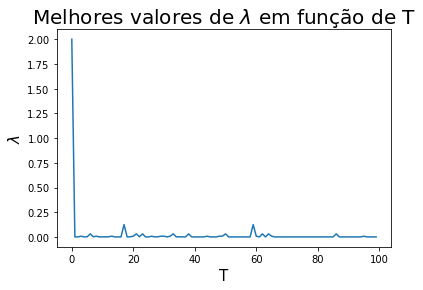

In [47]:
best_alpha = []
for i in range(len(min_values)):
    best_alpha.append((df_rmse.loc[df_rmse['RMSE'].values == min_values[i]]['alpha'].values))
plt.title(r'Melhores valores de $\lambda$ em função de T', size = 20)
plt.ylabel(r'$\lambda$', size = 15)
plt.xlabel('T', size = 15)
plt.plot(best_alpha)

# Análise dos valores de $\lambda$
- Analisando o gráfico acima notou-se que para muitos casos o valor de $\lambda$ mínimo, ou seja, 0.00048828125 é o valor ótimo. Isto mostra que o modelo não sofreu sobreajuste e portanto os valores de $\lambda$ não têm efeito.
- Em minha opinião, os valores de $\lambda$ deveriam crescer conforme T, pois um aumento no número de atributos tende a aumentar a norma do vetor $\pmb W$

Text(0, 0.5, 'RMSE')

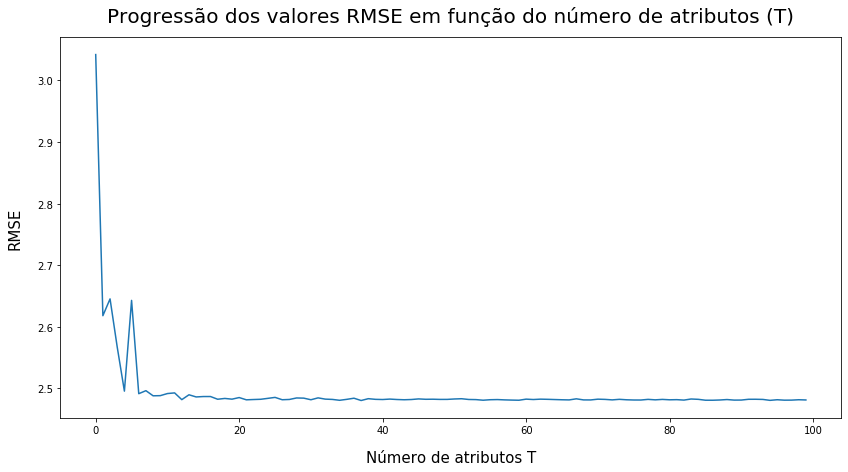

In [48]:
# plot RMSE(T)
plt.figure(figsize = (14,7))
plt.plot(df_rmse2["RMSE"])
plt.title("Progressão dos valores RMSE em função do número de atributos (T)", pad = 15, size = 20)
plt.xlabel("Número de atributos T", labelpad = 15, size = 15)
plt.ylabel("RMSE", labelpad = 15, size = 15)

# Análise do gráfico RMSE(T)
- Pela inspeção dos resultados acima, obteve-se que o menor valor de RMSE vale para um fator de regularização Alpha = 0.00048828125 com T = 18. Entretanto, nota-se que o valor RMSE não melhora tanto após T = 15, pois seus valores saturam a partir deste ponto. Sendo assim, reconhendo a semelhança entre o valor T e o número de neurônios de uma MLP, poderíamos estruturar a rede com T = 15. Neste caso, a rede continuaria com um baixo valor RMSE próximo a uma rede de muitos neurônios, porém muito menos complexa e mais simples no ponto de vista de recursos computacionais

# Avaliando o melhor modelo para conjunto de testes a partir do par ótimo ($\lambda$, T) = (0.00048828125, 18)

In [59]:
folders_phi, folders_y = kfold_n(data = df2, K = 10, n = 5)

# fold de test
fold_phi = np.concatenate([folders_phi[0],\
                             folders_phi[1],\
                             folders_phi[2],\
                             folders_phi[3],\
                             folders_phi[4],\
                             folders_phi[5],\
                             folders_phi[6],\
                             folders_phi[7],\
                             folders_phi[8]])
test_phi = folders_phi[9]

fold_y = np.concatenate([folders_y[0],\
                           folders_y[1],\
                           folders_y[2],\
                           folders_y[3],\
                           folders_y[4],\
                           folders_y[5],\
                           folders_y[6],\
                           folders_y[7],\
                           folders_y[8]])
test_y = folders_y[9]


X_5days, Y_5days = phi_y(data_phi = fold_phi, data_y = fold_y, n = 5)
W = np.array([[np.random.uniform(0, 1) for i in range(5)] for i in range(18+1)])         
Phi = np.zeros(shape = (len(Y_5days), 18+1))
            
for row in range(Phi.shape[0]):
    for column in range(Phi.shape[1]):
        Phi[row][column] = np.tanh(W[column].dot(X_5days[row]))
        
model_t_alpha_k = fit_reg_lin_lambda(X = Phi[:, 0:18+1], Y = Y_5days, alpha = 0.00048828125, add_ones = True)
#print ("Modelo: \n", model_t_alpha_k)

# Adiciona uma coluna de 1's para à matriz Phi para o peso w0           
X_Validation_5days, Y_Validation_5days = phi_y(data_phi = test_phi, data_y = test_y, n = 5)
# Calula a saída estimada do tipo Y = Phi.W
Phi_Validation = np.zeros(shape = (len(Y_Validation_5days), 18+1))
for row in range(Phi_Validation.shape[0]):
    for column in range(Phi_Validation.shape[1]):
        Phi_Validation[row][column] = np.tanh(W[column].dot(X_Validation_5days[row]))
Phi_Validation = np.c_[np.ones(len(Phi_Validation)), Phi_Validation]
y_estimated = Phi_Validation[:, 0:18+2].dot(model_t_alpha_k) #not sure what use as Phi for validation

# Calcula erro rmse
y_real = Y_Validation_5days
RMSE = float(rmse(y_est = y_estimated, y = y_real))
print(RMSE)

2.325793868060219


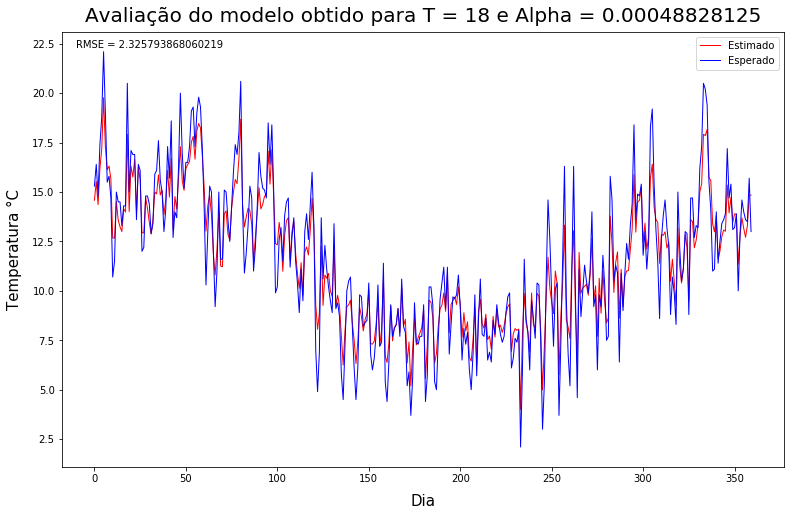

In [60]:
# Plotando as saídas reais e estimadas do melhor modelo encontrado
plt.figure(figsize = (12.944, 8))
for i in range(0, len(y_estimated)-1):
    if i == len(y_estimated):
        y_estimated[i] = y_estimated[i]
    else:
        y_estimated[i] = y_estimated[i+1]
plt.plot(y_estimated, color = "red", label = "Estimado", linewidth = 1)
plt.plot(y_real, color = "blue", label = "Esperado", linewidth = 1)
plt.title("Avaliação do modelo obtido para T = 18 e Alpha = 0.00048828125", fontsize = 20, pad = 10)
plt.text(x = -10, y = 22.3, s = "RMSE = "+ str(RMSE))
plt.xlabel("Dia", fontsize = 15, labelpad = 10)
plt.ylabel("Temperatura °C", fontsize = 15, labelpad = 10)
plt.legend()

# Curiosidade
- Se o cálculo de RMSE for tomado comparando a saída esperada y com a saída prevista y(n+1) o valor RMSE reduz de 2.32 para 1.32. Isto foi avaliado, a partir do momento que notei que as saídas estimadas estavam ligeraimente deslocadas à direita quando comparadas com as saídas esperadas